<a href="https://colab.research.google.com/github/mrMichalR/spaceship_titanic/blob/main/spaceship_titanic_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spaceship Titanic project

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good. The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars. While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension! To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system. Help save them and change history!

In [ ]:
# !pip install opendatasets
# !pip install ydata-profiling
!pip install catboost
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import opendatasets as od
import seaborn as sns
import pandas as pd
import numpy as np
import optuna
import logging
import sys
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from numpy import std, mean
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pandas import set_option
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
import catboost as cb
from sklearn.feature_extraction import DictVectorizer
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from optuna.integration import LightGBMPruningCallback, XGBoostPruningCallback, CatBoostPruningCallback

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# %cd drive/MyDrive/spaceship_titanic/

Mounted at /content/drive


## Get data 
Get data from link: https://www.kaggle.com/competitions/spaceship-titanic/data and read to your notebook.

In [ ]:
# dataset_url = 'https://www.kaggle.com/competitions/spaceship-titanic/data'
# od.download(dataset_url)

In [ ]:

# df = pd.read_csv('/content/spaceship-titanic/train.csv')
# df

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/spaceship_titanic/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/spaceship_titanic/test.csv')
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [ ]:
df_test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [ ]:
df[df.isnull().any(axis=1)]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
10,0008_02,Europa,True,B/1/P,TRAPPIST-1e,34.0,False,0.0,0.0,NaN,0.0,0.0,Altardr Flatic,True
15,0012_01,Earth,False,NaN,TRAPPIST-1e,31.0,False,32.0,0.0,876.0,0.0,0.0,Justie Pooles,False
16,0014_01,Mars,False,F/3/P,55 Cancri e,27.0,False,1286.0,122.0,NaN,0.0,0.0,Flats Eccle,False
23,0020_03,Earth,True,E/0/S,55 Cancri e,29.0,False,0.0,0.0,NaN,0.0,0.0,Mollen Mcfaddennon,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8667,9250_01,Europa,False,E/597/P,TRAPPIST-1e,29.0,False,0.0,2972.0,NaN,28.0,188.0,Chain Reedectied,True
8674,9257_01,NaN,False,F/1892/P,TRAPPIST-1e,13.0,False,39.0,0.0,1085.0,24.0,0.0,Ties Apple,False
8675,9259_01,Earth,NaN,F/1893/P,TRAPPIST-1e,44.0,False,1030.0,1015.0,0.0,11.0,NaN,Annah Gilleyons,True
8684,9274_01,NaN,True,G/1508/P,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,0.0,Chelsa Bullisey,True


In [ ]:
df.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

## Data analysis

Analyze the data and perform exploratory data analysis

### Plot histograms

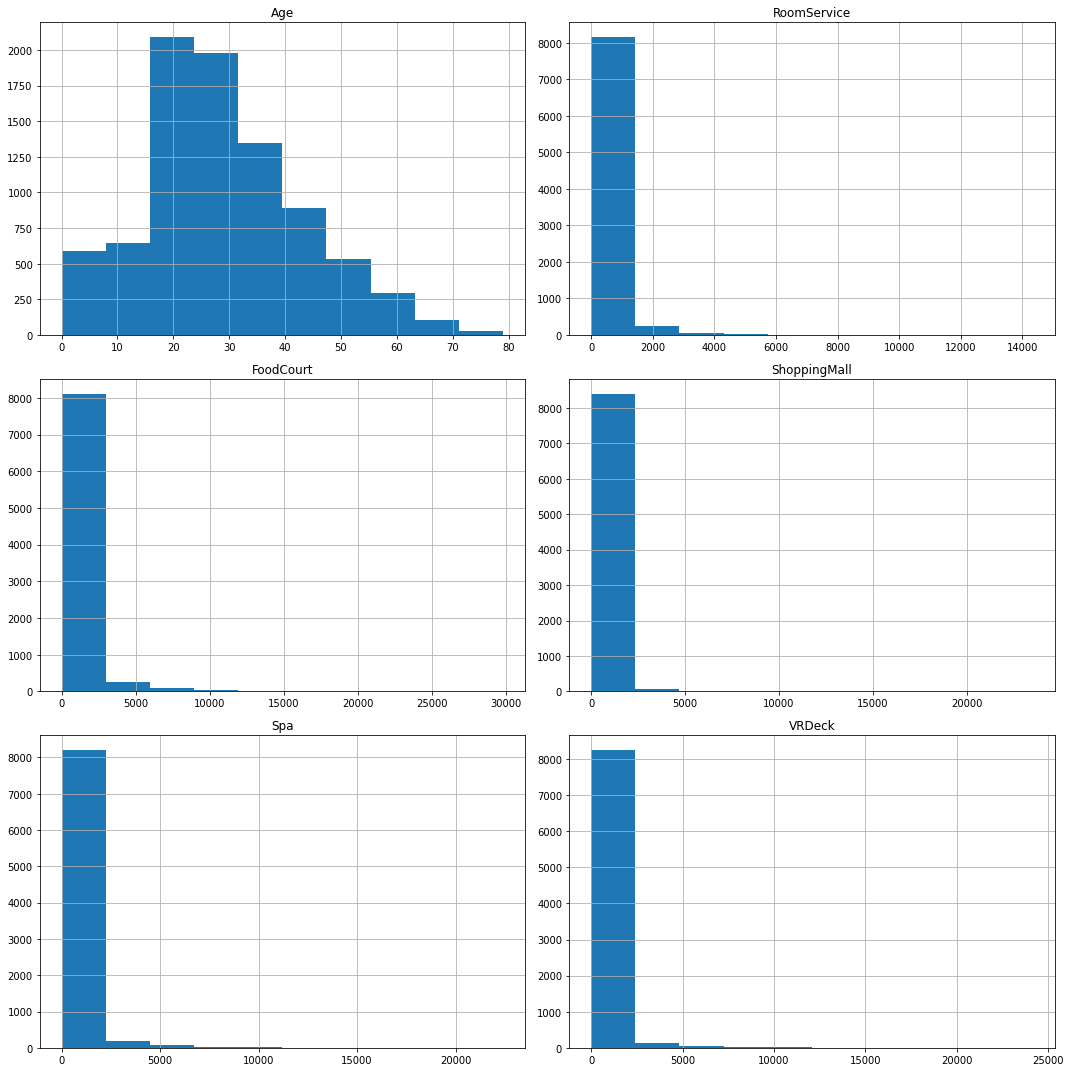

In [ ]:
# histogram
df.hist(figsize=(15,15))
plt.tight_layout()
plt.show()

### Identify correlations of data features and propose visual representation of the correlations.

In [ ]:
# correlation
# set_option('precision', 3)
df_corr = df.corr(method='pearson')
print(df_corr)

                   Age  RoomService  FoodCourt  ShoppingMall       Spa  \
Age           1.000000     0.068723   0.130421      0.033133  0.123970   
RoomService   0.068723     1.000000  -0.015889      0.054480  0.010080   
FoodCourt     0.130421    -0.015889   1.000000     -0.014228  0.221891   
ShoppingMall  0.033133     0.054480  -0.014228      1.000000  0.013879   
Spa           0.123970     0.010080   0.221891      0.013879  1.000000   
VRDeck        0.101007    -0.019581   0.227995     -0.007322  0.153821   
Transported  -0.075026    -0.244611   0.046566      0.010141 -0.221131   

                VRDeck  Transported  
Age           0.101007    -0.075026  
RoomService  -0.019581    -0.244611  
FoodCourt     0.227995     0.046566  
ShoppingMall -0.007322     0.010141  
Spa           0.153821    -0.221131  
VRDeck        1.000000    -0.207075  
Transported  -0.207075     1.000000  


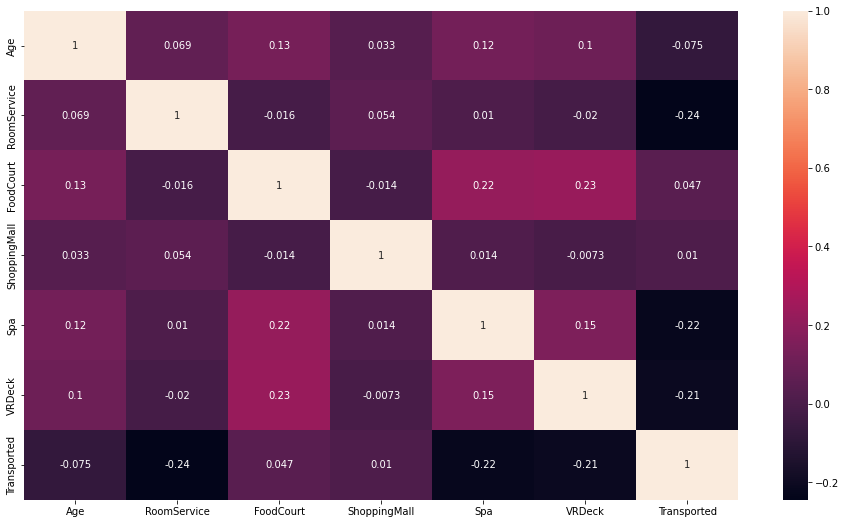

In [ ]:
# correlation visualization
plt.figure(figsize=(16,9))
sns.heatmap(df_corr, annot=True)
plt.show()

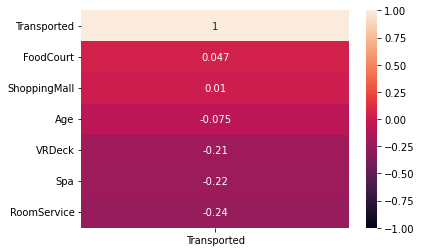

In [ ]:
heatmap = sns.heatmap(df.corr()[['Transported']].sort_values(by='Transported', ascending=False), vmin=-1, vmax=1, annot=True)

### Check if the dataset is balanced (if not think about methods to aquire balance)

In [ ]:
# target = "Transported"
df['Transported'].value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

Target feature balanced

### Use pandas profiler to generate report in html format

In [ ]:
# prof = ProfileReport(df)
# prof.to_file(output_file='output.html')

## Data preprocessing
Prepare data using preprocessing methods.

In [ ]:
target_name = "Transported"
X = df.drop(columns=[target_name])
y = df[target_name]
# y = df[target_name].astype(str)

In [ ]:
print(y,2*'\n')
print(X)

0       False
1        True
2       False
3       False
4        True
        ...  
8688    False
8689    False
8690     True
8691    False
8692     True
Name: Transported, Length: 8693, dtype: bool 


     PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0        0001_01     Europa     False     B/0/P    TRAPPIST-1e  39.0  False   
1        0002_01      Earth     False     F/0/S    TRAPPIST-1e  24.0  False   
2        0003_01     Europa     False     A/0/S    TRAPPIST-1e  58.0   True   
3        0003_02     Europa     False     A/0/S    TRAPPIST-1e  33.0  False   
4        0004_01      Earth     False     F/1/S    TRAPPIST-1e  16.0  False   
...          ...        ...       ...       ...            ...   ...    ...   
8688     9276_01     Europa     False    A/98/P    55 Cancri e  41.0   True   
8689     9278_01      Earth      True  G/1499/S  PSO J318.5-22  18.0  False   
8690     9279_01      Earth     False  G/1500/S    TRAPPIST-1e  26.0  False   
8691    

In [ ]:
X

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre


### Think and propose how represent categorical values

Proposition:
Since we are going to use tree-based models (XGB,LGBM, CB):
- encoding data with OrdinalEncoder is OK. 
- no need to endoce numerical.

Source: https://inria.github.io/scikit-learn-mooc/python_scripts/03_categorical_pipeline_column_transformer.html#fitting-a-more-powerful-model

___
Possible simplier solution is to use pandas replace with intiger values - will be checked.
https://www.kaggle.com/code/hussainsheriff/spaceship-titanic-tensor-flow
___

Alternative encoder one_hot_encoder or pd.get_dummies.

Encode categorical columns and check corr?

In [ ]:
# Ordinal encoder use with encoding unknown values woith -1 value

categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
# numerical_preprocessor = StandardScaler()


categorical_columns= X.select_dtypes(include=object).columns.tolist()
# numerical_columns = X.select_dtypes(exclude=object).columns.tolist()

In [ ]:
# Defining pipepline with prior iteration for missing values
categorical_pipeline = Pipeline(
    steps=[
        ("impute", IterativeImputer(random_state=42)),
        ("OrdEnc", categorical_preprocessor),
    ]
)

# numerical_pipeline = Pipeline(
#     steps=[
#         ("impute", IterativeImputer(random_state=42)),
#         # ("SS", numerical_preprocessor),
#     ]
# )

In [ ]:
print(f'Before convert:\n{X.dtypes}\n')

# Convert categorical columns to Pandas category
for col in categorical_columns:
   X[col] = X[col].astype('category')

print(f'After convert:\n{X.dtypes}\n')

Before convert:
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
dtype: object

After convert:
PassengerId     category
HomePlanet      category
CryoSleep       category
Cabin           category
Destination     category
Age              float64
VIP             category
RoomService      float64
FoodCourt        float64
ShoppingMall     float64
Spa              float64
VRDeck           float64
Name            category
dtype: object



In [ ]:
# feature_names = categorical_preprocessor.get_feature_names_out()
# df_enc = pd.DataFrame(categorical_columns, columns=feature_names)
# df_enc_col=df_enc.columns.tolist()
# df_enc_col

In [ ]:
# df_enc.dtypes

In [ ]:
# df_cat = df[cat_col]
# # df_cat

# encoder=OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
# df_encoded = encoder.fit_transform(df_cat)
# print(df_encoded)

# columns_encoded = encoder.get_feature_names_out(df_cat.columns)
# print(pd.DataFrame(df_encoded, columns=columns_encoded).head())

### Think and propose how to handle nulls and nan values

Proposition:
* More pro - impute (e.g. IterativeImputer) - included in above point
* The simplest approach is to remove. In this case dropping caused dataset reduction from 8693 to 6606 -> 2087 rows dropped ! -below


In [ ]:
# #Drop missing values
# X.dropna(inplace=True)
# print(f'Numeric nulls:\n{X.select_dtypes(include=np.number).isnull().sum()}\n')
# print(f'Categorical nulls:\n{X.select_dtypes(exclude=np.number).isna().sum()}\n')

# # Convert to intigers
# X=X.astype(int)
# X.isnull().sum()

### Divide dataset into train, validation and test subset

Since we have test dataset our train will be split into train and validation.

In [ ]:
# #Split of dataset to train, validation ('val') and test 
# X_train, X_test_temp, y_train, y_test_temp = train_test_split(X, y, test_size=0.4, train_size=0.6)
# X_test, X_val, y_test, y_val = train_test_split(X_test_temp,y_test_temp, test_size = 0.5, train_size =0.5)

# print('TRAIN set:\n', 'X_train:', X_train.shape, '\n y_train: ', y_train.shape)
# print('VAL set:\n', 'X_val:', X_val.shape, '\n y_val: ', y_val.shape)
# print('TEST set:\n', 'X_test:', X_test.shape, '\n y_test: ', y_test.shape)


#Split of train to train and validation ('val') 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3)

print(2*'\n')
print('TRAIN set:\n', 'X_train:', X_train.shape, '\n y_train2: ', y_train.shape)
print('VAL set:\n', 'X_val:', X_val.shape, '\n y_val2: ', y_val.shape)




TRAIN set:
 X_train: (6085, 13) 
 y_train2:  (6085,)
VAL set:
 X_val: (2608, 13) 
 y_val2:  (2608,)


## Machine learning methods
Use standard ML algorithms to classify passengers.

In [ ]:
# enc_col = categorical_preprocessor.fit_transform(df[cat_col])

# preprocessor = ColumnTransformer([
#     ('one-hot-encoder', categorical_preprocessor, categorical_columns),
#     ('standard_scaler', numerical_preprocessor, numerical_columns)])

preprocessor = ColumnTransformer([('categorical', categorical_preprocessor, categorical_columns)], remainder="passthrough")
# preprocessor

### Use XGBoost, LightGBM and CatBoost.

In [ ]:
# Spot-Check Algorithms
models = []
models.append(('XGB', XGBClassifier()))
models.append(('LightGBM', LGBMClassifier()))
models.append(('CatBoost', CatBoostClassifier(logging_level='Silent')))

### Choose metrics you want to use to evaluate those models,

Accuracy by default but in thi scase recall might be more informative

In [ ]:
# model_name = []
# name = []
# for name, model_name in models:
#   model = make_pipeline(preprocessor, model_name)
#   model.fit(X_train, y_train)
#   model.predict(X_test)
#   if name =='CatBoost':
#     print(f'{name} accuracy: {accuracy_score(y_test.astype(str), model.predict(X_test))}')
#     print(f'{name} recall: {recall_score(y_test.astype(str), model.predict(X_test))}')
#     # print(f'{name} precision: {precision_score(y_test.astype(str), model.predict(X_test), average="macro")}')
#     print(f'{name} f1_score: {f1_score(y_test.astype(str), model.predict(X_test))}')
#   else:
#     print(f'{name} accuracy: {model.score(X_test, y_test)}')
#     print(f'{name} recall: {recall_score(y_test, model.predict(X_test))}')
#     # print(f'{name} precision: {precision_score(y_test, model.predict(X_test), average="macro")}')
#     print(f'{name} f1_score: {f1_score(y_test, model.predict(X_test))}')

In [ ]:
model_name = []
name = []
for name, model_name in models:
  model = make_pipeline(preprocessor, model_name)
  model.fit(X_train, y_train)
  model.predict(X_val)
  if name =='CatBoost':
    print(f'{name} accuracy: {accuracy_score(y_val.astype(str), model.predict(X_val).3f)}')
    print(f'{name} recall: {recall_score(y_val.astype(str), model.predict(X_val), average="binary", pos_label="False").3f}')
    # print(f'{name} precision: {precision_score(y_val2.astype(str), model.predict(X_val2), average="macro")}')
    print(f'{name} f1_score: {f1_score(y_val.astype(str), model.predict(X_val),average="binary", pos_label="False").3f}')
    print('\n')
  else:
    print(f'{name} accuracy: {model.score(X_val, y_val).3f}')
    print(f'{name} recall: {recall_score(y_val, model.predict(X_val)).3f}')
    # print(f'{name} precision: {precision_score(y_val2, model.predict(X_val2), average="macro")}')
    print(f'{name} f1_score: {f1_score(y_val, model.predict(X_val)).3f}')
    print('\n')

XGB accuracy: 0.7664877300613497
XGB recall: 0.7989337395277989
XGB f1_score: 0.7750277059475434


LightGBM accuracy: 0.7845092024539877
LightGBM recall: 0.8789032749428789
LightGBM f1_score: 0.8041811846689895


CatBoost accuracy: 0.785659509202454
CatBoost recall: 0.7320463320463321
CatBoost f1_score: 0.7723014256619145




### Use Optuna to find the best hyperparameters.

#### LGBM

In [ ]:
'''
SOURCE: 
https://colab.research.google.com/drive/1Mj9hF54UESVDRmpA09tWADq9Nbrj6M-2?usp=sharing#scrollTo=9a1haMklJ6X3
'''

# Define the objective function.
def objective(trial):
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_val, label=y_val)
    #default parameters dictionary for optimizations(search space)
    param = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    # Add a callback for pruning.
    # To turn on the pruning feature, you need to call :func:`~optuna.trial.Trial.report` and :func:`~optuna.trial.Trial.should_prune` after each step of the iterative training.
    # :func:`~optuna.trial.Trial.report` periodically monitors the intermediate objective values.
    # :func:`~optuna.trial.Trial.should_prune` decides termination of the trial that does not meet a predefined condition.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "auc")
    gbm = lgb.train(param, dtrain, valid_sets=[dvalid], verbose_eval=False, callbacks=[pruning_callback])
    #Predict the valid data
    preds = gbm.predict(X_val)
    #rounding values to its nearest integers
    pred_labels = np.rint(preds)
    #calculating accuracy
    accuracy = accuracy_score(y_val, pred_labels)
    return accuracy

'''
Create an study for that ML model and optimize it
'''

# Add stream handler of stdout to show the messages
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
# Method :func:`~optuna.create_study` returns a study object.
# A study object has useful properties for analyzing the optimization outcome.
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
) #Set minimize for minimization and maximize for maximization.
#To start the optimization, we create a study object and pass the objective function to method
study.optimize(objective, n_trials=100, timeout=600) #add timeout for model not to exceed this time limit


# To get the dictionary of parameter name and parameter values:
print("Return a dictionary of parameter name and parameter values:\n",study.best_params)

# To get the best observed value of the objective function:
print("Return the best observed value of the objective function:\n",study.best_value)

# # To get the best trial:
# print("Return the best trial:",study.best_trial)

# # To get all trials:
# print("Return all the trials:", study.trials)

# study.trials_dataframe()

[I 2023-03-20 00:03:06,114] A new study created in memory with name: no-name-88774871-a804-46ee-8264-5371815f6ac4


A new study created in memory with name: no-name-88774871-a804-46ee-8264-5371815f6ac4


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:07,505] Trial 0 finished with value: 0.7910276073619632 and parameters: {'bagging_fraction': 0.4955611908580424, 'bagging_freq': 4, 'min_child_samples': 56}. Best is trial 0 with value: 0.7910276073619632.


Trial 0 finished with value: 0.7910276073619632 and parameters: {'bagging_fraction': 0.4955611908580424, 'bagging_freq': 4, 'min_child_samples': 56}. Best is trial 0 with value: 0.7910276073619632.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:08,686] Trial 1 finished with value: 0.8002300613496932 and parameters: {'bagging_fraction': 0.8045493228788212, 'bagging_freq': 4, 'min_child_samples': 91}. Best is trial 1 with value: 0.8002300613496932.


Trial 1 finished with value: 0.8002300613496932 and parameters: {'bagging_fraction': 0.8045493228788212, 'bagging_freq': 4, 'min_child_samples': 91}. Best is trial 1 with value: 0.8002300613496932.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:08,982] Trial 2 finished with value: 0.7975460122699386 and parameters: {'bagging_fraction': 0.8558373798785077, 'bagging_freq': 2, 'min_child_samples': 62}. Best is trial 1 with value: 0.8002300613496932.


Trial 2 finished with value: 0.7975460122699386 and parameters: {'bagging_fraction': 0.8558373798785077, 'bagging_freq': 2, 'min_child_samples': 62}. Best is trial 1 with value: 0.8002300613496932.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:09,308] Trial 3 finished with value: 0.7917944785276073 and parameters: {'bagging_fraction': 0.8747014442278773, 'bagging_freq': 3, 'min_child_samples': 39}. Best is trial 1 with value: 0.8002300613496932.


Trial 3 finished with value: 0.7917944785276073 and parameters: {'bagging_fraction': 0.8747014442278773, 'bagging_freq': 3, 'min_child_samples': 39}. Best is trial 1 with value: 0.8002300613496932.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:09,585] Trial 4 finished with value: 0.8025306748466258 and parameters: {'bagging_fraction': 0.457903950039216, 'bagging_freq': 3, 'min_child_samples': 66}. Best is trial 4 with value: 0.8025306748466258.


Trial 4 finished with value: 0.8025306748466258 and parameters: {'bagging_fraction': 0.457903950039216, 'bagging_freq': 3, 'min_child_samples': 66}. Best is trial 4 with value: 0.8025306748466258.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:09,642] Trial 5 pruned. Trial was pruned at iteration 12.


Trial 5 pruned. Trial was pruned at iteration 12.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:09,696] Trial 6 pruned. Trial was pruned at iteration 12.


Trial 6 pruned. Trial was pruned at iteration 12.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:09,766] Trial 7 pruned. Trial was pruned at iteration 12.


Trial 7 pruned. Trial was pruned at iteration 12.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:10,083] Trial 8 finished with value: 0.7998466257668712 and parameters: {'bagging_fraction': 0.9302514897204057, 'bagging_freq': 5, 'min_child_samples': 32}. Best is trial 4 with value: 0.8025306748466258.


Trial 8 finished with value: 0.7998466257668712 and parameters: {'bagging_fraction': 0.9302514897204057, 'bagging_freq': 5, 'min_child_samples': 32}. Best is trial 4 with value: 0.8025306748466258.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:10,157] Trial 9 pruned. Trial was pruned at iteration 18.


Trial 9 pruned. Trial was pruned at iteration 18.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:10,221] Trial 10 pruned. Trial was pruned at iteration 10.


Trial 10 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:10,290] Trial 11 pruned. Trial was pruned at iteration 10.


Trial 11 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:10,355] Trial 12 pruned. Trial was pruned at iteration 10.


Trial 12 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:10,423] Trial 13 pruned. Trial was pruned at iteration 10.


Trial 13 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:10,533] Trial 14 pruned. Trial was pruned at iteration 11.


Trial 14 pruned. Trial was pruned at iteration 11.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:10,616] Trial 15 pruned. Trial was pruned at iteration 10.


Trial 15 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:10,685] Trial 16 pruned. Trial was pruned at iteration 10.


Trial 16 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:10,756] Trial 17 pruned. Trial was pruned at iteration 10.


Trial 17 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:10,839] Trial 18 pruned. Trial was pruned at iteration 12.


Trial 18 pruned. Trial was pruned at iteration 12.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:10,912] Trial 19 pruned. Trial was pruned at iteration 10.


Trial 19 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:11,010] Trial 20 pruned. Trial was pruned at iteration 20.


Trial 20 pruned. Trial was pruned at iteration 20.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:11,104] Trial 21 pruned. Trial was pruned at iteration 14.


Trial 21 pruned. Trial was pruned at iteration 14.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:11,770] Trial 22 finished with value: 0.7979294478527608 and parameters: {'bagging_fraction': 0.8669204760018057, 'bagging_freq': 5, 'min_child_samples': 22}. Best is trial 4 with value: 0.8025306748466258.


Trial 22 finished with value: 0.7979294478527608 and parameters: {'bagging_fraction': 0.8669204760018057, 'bagging_freq': 5, 'min_child_samples': 22}. Best is trial 4 with value: 0.8025306748466258.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:13,881] Trial 23 finished with value: 0.8017638036809815 and parameters: {'bagging_fraction': 0.8110920302131476, 'bagging_freq': 4, 'min_child_samples': 48}. Best is trial 4 with value: 0.8025306748466258.


Trial 23 finished with value: 0.8017638036809815 and parameters: {'bagging_fraction': 0.8110920302131476, 'bagging_freq': 4, 'min_child_samples': 48}. Best is trial 4 with value: 0.8025306748466258.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:14,210] Trial 24 pruned. Trial was pruned at iteration 24.


Trial 24 pruned. Trial was pruned at iteration 24.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:14,453] Trial 25 pruned. Trial was pruned at iteration 11.


Trial 25 pruned. Trial was pruned at iteration 11.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:14,985] Trial 26 pruned. Trial was pruned at iteration 10.


Trial 26 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:15,185] Trial 27 pruned. Trial was pruned at iteration 10.


Trial 27 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:16,671] Trial 28 finished with value: 0.799079754601227 and parameters: {'bagging_fraction': 0.8338037446439429, 'bagging_freq': 3, 'min_child_samples': 43}. Best is trial 4 with value: 0.8025306748466258.


Trial 28 finished with value: 0.799079754601227 and parameters: {'bagging_fraction': 0.8338037446439429, 'bagging_freq': 3, 'min_child_samples': 43}. Best is trial 4 with value: 0.8025306748466258.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:16,741] Trial 29 pruned. Trial was pruned at iteration 10.


Trial 29 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:16,813] Trial 30 pruned. Trial was pruned at iteration 11.


Trial 30 pruned. Trial was pruned at iteration 11.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:16,889] Trial 31 pruned. Trial was pruned at iteration 10.


Trial 31 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:16,971] Trial 32 pruned. Trial was pruned at iteration 10.


Trial 32 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:17,064] Trial 33 pruned. Trial was pruned at iteration 10.


Trial 33 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:17,160] Trial 34 pruned. Trial was pruned at iteration 15.


Trial 34 pruned. Trial was pruned at iteration 15.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:17,238] Trial 35 pruned. Trial was pruned at iteration 10.


Trial 35 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:17,326] Trial 36 pruned. Trial was pruned at iteration 11.


Trial 36 pruned. Trial was pruned at iteration 11.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:17,398] Trial 37 pruned. Trial was pruned at iteration 10.


Trial 37 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:17,494] Trial 38 pruned. Trial was pruned at iteration 18.


Trial 38 pruned. Trial was pruned at iteration 18.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:17,572] Trial 39 pruned. Trial was pruned at iteration 10.


Trial 39 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:17,658] Trial 40 pruned. Trial was pruned at iteration 10.


Trial 40 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:17,737] Trial 41 pruned. Trial was pruned at iteration 10.


Trial 41 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:18,112] Trial 42 finished with value: 0.7998466257668712 and parameters: {'bagging_fraction': 0.8456094898133372, 'bagging_freq': 2, 'min_child_samples': 45}. Best is trial 4 with value: 0.8025306748466258.


Trial 42 finished with value: 0.7998466257668712 and parameters: {'bagging_fraction': 0.8456094898133372, 'bagging_freq': 2, 'min_child_samples': 45}. Best is trial 4 with value: 0.8025306748466258.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:18,203] Trial 43 pruned. Trial was pruned at iteration 20.


Trial 43 pruned. Trial was pruned at iteration 20.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:18,290] Trial 44 pruned. Trial was pruned at iteration 11.


Trial 44 pruned. Trial was pruned at iteration 11.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:18,372] Trial 45 pruned. Trial was pruned at iteration 11.


Trial 45 pruned. Trial was pruned at iteration 11.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:18,451] Trial 46 pruned. Trial was pruned at iteration 10.


Trial 46 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:18,524] Trial 47 pruned. Trial was pruned at iteration 10.


Trial 47 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:18,624] Trial 48 pruned. Trial was pruned at iteration 10.


Trial 48 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:19,672] Trial 49 pruned. Trial was pruned at iteration 19.


Trial 49 pruned. Trial was pruned at iteration 19.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:19,810] Trial 50 pruned. Trial was pruned at iteration 10.


Trial 50 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:20,147] Trial 51 pruned. Trial was pruned at iteration 10.


Trial 51 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:20,442] Trial 52 pruned. Trial was pruned at iteration 20.


Trial 52 pruned. Trial was pruned at iteration 20.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:21,889] Trial 53 finished with value: 0.8009969325153374 and parameters: {'bagging_fraction': 0.7799538556171393, 'bagging_freq': 2, 'min_child_samples': 50}. Best is trial 4 with value: 0.8025306748466258.


Trial 53 finished with value: 0.8009969325153374 and parameters: {'bagging_fraction': 0.7799538556171393, 'bagging_freq': 2, 'min_child_samples': 50}. Best is trial 4 with value: 0.8025306748466258.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:22,226] Trial 54 pruned. Trial was pruned at iteration 11.


Trial 54 pruned. Trial was pruned at iteration 11.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:22,311] Trial 55 pruned. Trial was pruned at iteration 12.


Trial 55 pruned. Trial was pruned at iteration 12.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:22,400] Trial 56 pruned. Trial was pruned at iteration 17.


Trial 56 pruned. Trial was pruned at iteration 17.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:22,510] Trial 57 pruned. Trial was pruned at iteration 18.


Trial 57 pruned. Trial was pruned at iteration 18.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:22,589] Trial 58 pruned. Trial was pruned at iteration 10.


Trial 58 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:22,670] Trial 59 pruned. Trial was pruned at iteration 11.


Trial 59 pruned. Trial was pruned at iteration 11.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:22,751] Trial 60 pruned. Trial was pruned at iteration 10.


Trial 60 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:22,835] Trial 61 pruned. Trial was pruned at iteration 10.


Trial 61 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:22,924] Trial 62 pruned. Trial was pruned at iteration 10.


Trial 62 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:23,004] Trial 63 pruned. Trial was pruned at iteration 10.


Trial 63 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:23,363] Trial 64 finished with value: 0.7979294478527608 and parameters: {'bagging_fraction': 0.7749203964834794, 'bagging_freq': 4, 'min_child_samples': 37}. Best is trial 4 with value: 0.8025306748466258.


Trial 64 finished with value: 0.7979294478527608 and parameters: {'bagging_fraction': 0.7749203964834794, 'bagging_freq': 4, 'min_child_samples': 37}. Best is trial 4 with value: 0.8025306748466258.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:23,442] Trial 65 pruned. Trial was pruned at iteration 10.


Trial 65 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:23,515] Trial 66 pruned. Trial was pruned at iteration 10.


Trial 66 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:23,638] Trial 67 pruned. Trial was pruned at iteration 25.


Trial 67 pruned. Trial was pruned at iteration 25.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:23,735] Trial 68 pruned. Trial was pruned at iteration 19.


Trial 68 pruned. Trial was pruned at iteration 19.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:23,829] Trial 69 pruned. Trial was pruned at iteration 10.


Trial 69 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:23,914] Trial 70 pruned. Trial was pruned at iteration 10.


Trial 70 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:24,003] Trial 71 pruned. Trial was pruned at iteration 10.


Trial 71 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:24,091] Trial 72 pruned. Trial was pruned at iteration 10.


Trial 72 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:24,166] Trial 73 pruned. Trial was pruned at iteration 10.


Trial 73 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:24,259] Trial 74 pruned. Trial was pruned at iteration 12.


Trial 74 pruned. Trial was pruned at iteration 12.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:24,357] Trial 75 pruned. Trial was pruned at iteration 11.


Trial 75 pruned. Trial was pruned at iteration 11.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:24,443] Trial 76 pruned. Trial was pruned at iteration 11.


Trial 76 pruned. Trial was pruned at iteration 11.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:24,566] Trial 77 pruned. Trial was pruned at iteration 19.


Trial 77 pruned. Trial was pruned at iteration 19.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:24,652] Trial 78 pruned. Trial was pruned at iteration 10.


Trial 78 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:25,076] Trial 79 finished with value: 0.7975460122699386 and parameters: {'bagging_fraction': 0.8280528990713234, 'bagging_freq': 3, 'min_child_samples': 46}. Best is trial 4 with value: 0.8025306748466258.


Trial 79 finished with value: 0.7975460122699386 and parameters: {'bagging_fraction': 0.8280528990713234, 'bagging_freq': 3, 'min_child_samples': 46}. Best is trial 4 with value: 0.8025306748466258.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:25,150] Trial 80 pruned. Trial was pruned at iteration 10.


Trial 80 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:25,228] Trial 81 pruned. Trial was pruned at iteration 11.


Trial 81 pruned. Trial was pruned at iteration 11.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:25,330] Trial 82 pruned. Trial was pruned at iteration 11.


Trial 82 pruned. Trial was pruned at iteration 11.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:25,410] Trial 83 pruned. Trial was pruned at iteration 11.


Trial 83 pruned. Trial was pruned at iteration 11.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:25,493] Trial 84 pruned. Trial was pruned at iteration 10.


Trial 84 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:25,577] Trial 85 pruned. Trial was pruned at iteration 10.


Trial 85 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:25,657] Trial 86 pruned. Trial was pruned at iteration 11.


Trial 86 pruned. Trial was pruned at iteration 11.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:25,749] Trial 87 pruned. Trial was pruned at iteration 10.


Trial 87 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:25,840] Trial 88 pruned. Trial was pruned at iteration 10.


Trial 88 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:25,932] Trial 89 pruned. Trial was pruned at iteration 10.


Trial 89 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:26,013] Trial 90 pruned. Trial was pruned at iteration 10.


Trial 90 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:26,403] Trial 91 finished with value: 0.7983128834355828 and parameters: {'bagging_fraction': 0.840201881430071, 'bagging_freq': 2, 'min_child_samples': 53}. Best is trial 4 with value: 0.8025306748466258.


Trial 91 finished with value: 0.7983128834355828 and parameters: {'bagging_fraction': 0.840201881430071, 'bagging_freq': 2, 'min_child_samples': 53}. Best is trial 4 with value: 0.8025306748466258.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:26,480] Trial 92 pruned. Trial was pruned at iteration 10.


Trial 92 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:26,581] Trial 93 pruned. Trial was pruned at iteration 10.


Trial 93 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:26,668] Trial 94 pruned. Trial was pruned at iteration 12.


Trial 94 pruned. Trial was pruned at iteration 12.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:26,752] Trial 95 pruned. Trial was pruned at iteration 10.


Trial 95 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:26,844] Trial 96 pruned. Trial was pruned at iteration 11.


Trial 96 pruned. Trial was pruned at iteration 11.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:26,940] Trial 97 pruned. Trial was pruned at iteration 10.


Trial 97 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:27,028] Trial 98 pruned. Trial was pruned at iteration 10.


Trial 98 pruned. Trial was pruned at iteration 10.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-20 00:03:27,118] Trial 99 pruned. Trial was pruned at iteration 10.


Trial 99 pruned. Trial was pruned at iteration 10.
Return a dictionary of parameter name and parameter values:
 {'bagging_fraction': 0.457903950039216, 'bagging_freq': 3, 'min_child_samples': 66}
Return the best observed value of the objective function:
 0.8025306748466258


In [ ]:
# Visualize the optimization history. See :func:`~optuna.visualization.plot_optimization_history` for the details.
plot_optimization_history(study)

In [ ]:
# Visualize parameter importances. See :func:`~optuna.visualization.plot_param_importances` for the details.
plot_param_importances(study)

#### XGB

In [ ]:
'''
SOURCE: 
https://practicaldatascience.co.uk/machine-learning/how-to-use-optuna-for-xgboost-hyperparameter-tuning
+
https://medium.com/optuna/using-optuna-to-optimize-xgboost-hyperparameters-63bfcdfd3407
'''

# Define the objective function.
def objective_xgb(trial):
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False,
        'predictor': "gpu_predictor",
        'eval_metric' : 'auc',
        'objective' : 'binary:logistic',
        'tree_method': 'gpu_hist',
    }

    # # Fit the model
    # optuna_model = XGBClassifier(**params)
    # optuna_model.fit(X_train, y_train)

    # # Make predictions
    # y_pred = optuna_model.predict(X_val)

    # # Evaluate predictions
    # accuracy = accuracy_score(y_val, y_pred)
    # return accuracy

# Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    bst = xgb.train(param, dtrain, evals=[(dval, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dval)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_val, pred_labels)
    return accuracy



'''
Create an study for that ML model and optimize it
'''
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
) #Set minimize for minimization and maximize for maximization.

#To start the optimization, we create a study object and pass the objective function to method
study.optimize(objective_xgb, n_trials=100, timeout=600) #add timeout for model not to exceed this time limit


# To get the dictionary of parameter name and parameter values:
print(f"Return a dictionary of parameter name and parameter values:\n{study.best_params}")

# To get the best observed value of the objective function:
print("Return the best observed value of the objective function:",study.best_value)

# # To get the best trial:
# print("Return the best trial:",study.best_trial)

# # To get all trials:
# print("Return all the trials:", study.trials)

# study.trials_dataframe()

[I 2023-03-20 00:03:27,552] A new study created in memory with name: no-name-a1450fb1-897c-42be-92ec-3000c0b38ca8


A new study created in memory with name: no-name-a1450fb1-897c-42be-92ec-3000c0b38ca8
[00:03:28] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.73180
[1]	validation-auc:0.78869
[2]	validation-auc:0.79838
[3]	validation-auc:0.80250
[4]	validation-auc:0.80817
[5]	validation-auc:0.80416
[6]	validation-auc:0.82339
[7]	validation-auc:0.83025
[8]	validation-auc:0.83908
[9]	validation-auc:0.84021


[I 2023-03-20 00:03:28,117] Trial 0 finished with value: 0.7730061349693251 and parameters: {'max_depth': 3, 'learning_rate': 0.31563672819054606, 'n_estimators': 263, 'min_child_weight': 1, 'gamma': 1.2420266162858936e-08, 'subsample': 0.0837427112628802, 'colsample_bytree': 0.36004158193880087, 'reg_alpha': 7.56468112454884e-06, 'reg_lambda': 2.101519267190238e-07}. Best is trial 0 with value: 0.7730061349693251.


Trial 0 finished with value: 0.7730061349693251 and parameters: {'max_depth': 3, 'learning_rate': 0.31563672819054606, 'n_estimators': 263, 'min_child_weight': 1, 'gamma': 1.2420266162858936e-08, 'subsample': 0.0837427112628802, 'colsample_bytree': 0.36004158193880087, 'reg_alpha': 7.56468112454884e-06, 'reg_lambda': 2.101519267190238e-07}. Best is trial 0 with value: 0.7730061349693251.
[00:03:28] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.49414
[1]	validation-auc:0.67260
[2]	validation-auc:0.72316
[3]	validation-auc:0.72316
[4]	validation-auc:0.72292
[5]	validation-auc:0.72370
[6]	validation-auc:0.72370
[7]	validation-auc:0.73074
[8]	validation-auc:0.72286
[9]	validation-auc:0.72286


[I 2023-03-20 00:03:28,205] Trial 1 finished with value: 0.6591257668711656 and parameters: {'max_depth': 1, 'learning_rate': 0.010475102555156473, 'n_estimators': 137, 'min_child_weight': 10, 'gamma': 0.0002879733968290103, 'subsample': 0.07761577508545207, 'colsample_bytree': 0.03464795742853375, 'reg_alpha': 0.03470716954178827, 'reg_lambda': 1.3343818835925194e-06}. Best is trial 0 with value: 0.7730061349693251.


Trial 1 finished with value: 0.6591257668711656 and parameters: {'max_depth': 1, 'learning_rate': 0.010475102555156473, 'n_estimators': 137, 'min_child_weight': 10, 'gamma': 0.0002879733968290103, 'subsample': 0.07761577508545207, 'colsample_bytree': 0.03464795742853375, 'reg_alpha': 0.03470716954178827, 'reg_lambda': 1.3343818835925194e-06}. Best is trial 0 with value: 0.7730061349693251.
[00:03:28] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.78732
[1]	validation-auc:0.82034
[2]	validation-auc:0.82367
[3]	validation-auc:0.83870
[4]	validation-auc:0.84037
[5]	validation-auc:0.84125
[6]	validation-auc:0.84580
[7]	validation-auc:0.84935
[8]	validation-auc:0.85241
[9]	validation-auc:0.85169


[I 2023-03-20 00:03:28,356] Trial 2 finished with value: 0.7756901840490797 and parameters: {'max_depth': 8, 'learning_rate': 0.1116718717168118, 'n_estimators': 192, 'min_child_weight': 9, 'gamma': 6.214383603240166e-05, 'subsample': 0.11233345775440101, 'colsample_bytree': 0.5764761309245493, 'reg_alpha': 0.0010066174725819927, 'reg_lambda': 7.404218858844313e-08}. Best is trial 2 with value: 0.7756901840490797.


Trial 2 finished with value: 0.7756901840490797 and parameters: {'max_depth': 8, 'learning_rate': 0.1116718717168118, 'n_estimators': 192, 'min_child_weight': 9, 'gamma': 6.214383603240166e-05, 'subsample': 0.11233345775440101, 'colsample_bytree': 0.5764761309245493, 'reg_alpha': 0.0010066174725819927, 'reg_lambda': 7.404218858844313e-08}. Best is trial 2 with value: 0.7756901840490797.
[00:03:28] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-03-20 00:03:28,442] Trial 3 finished with value: 0.5034509202453987 and parameters: {'max_depth': 9, 'learning_rate': 0.3497542549014235, 'n_estimators': 451, 'min_child_weight': 8, 'gamma': 0.07694011179769845, 'subsample': 0.010206043403679026, 'colsample_bytree': 0.028099259291127724, 'reg_alpha': 2.716928664563782e-08, 'reg_lambda': 0.4799756036610437}. Best is trial 2 with value: 0.7756901840490797.


Trial 3 finished with value: 0.5034509202453987 and parameters: {'max_depth': 9, 'learning_rate': 0.3497542549014235, 'n_estimators': 451, 'min_child_weight': 8, 'gamma': 0.07694011179769845, 'subsample': 0.010206043403679026, 'colsample_bytree': 0.028099259291127724, 'reg_alpha': 2.716928664563782e-08, 'reg_lambda': 0.4799756036610437}. Best is trial 2 with value: 0.7756901840490797.
[00:03:28] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.73308
[1]	validation-auc:0.75360
[2]	validation-auc:0.78514
[3]	validation-auc:0.81053
[4]	validation-auc:0.81316
[5]	validation-auc:0.80973
[6]	validation-auc:0.80886
[7]	validation-auc:0.81590
[8]	validation-auc:0.81462
[9]	validation-auc:0.81772


[I 2023-03-20 00:03:28,578] Trial 4 finished with value: 0.745782208588957 and parameters: {'max_depth': 8, 'learning_rate': 0.29114928573253157, 'n_estimators': 365, 'min_child_weight': 1, 'gamma': 1.431803706188593e-07, 'subsample': 0.01276041221515007, 'colsample_bytree': 0.668416727145229, 'reg_alpha': 0.6258742227242018, 'reg_lambda': 0.0002979427141483943}. Best is trial 2 with value: 0.7756901840490797.


Trial 4 finished with value: 0.745782208588957 and parameters: {'max_depth': 8, 'learning_rate': 0.29114928573253157, 'n_estimators': 365, 'min_child_weight': 1, 'gamma': 1.431803706188593e-07, 'subsample': 0.01276041221515007, 'colsample_bytree': 0.668416727145229, 'reg_alpha': 0.6258742227242018, 'reg_lambda': 0.0002979427141483943}. Best is trial 2 with value: 0.7756901840490797.
[00:03:28] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.50000
[1]	validation-auc:0.64287
[2]	validation-auc:0.67736
[3]	validation-auc:0.67736
[4]	validation-auc:0.67638
[5]	validation-auc:0.67638
[6]	validation-auc:0.67638
[7]	validation-auc:0.71473
[8]	validation-auc:0.71358
[9]	validation-auc:0.71358


[I 2023-03-20 00:03:28,669] Trial 5 finished with value: 0.6759969325153374 and parameters: {'max_depth': 3, 'learning_rate': 0.547003937997193, 'n_estimators': 187, 'min_child_weight': 3, 'gamma': 1.6503278885423187e-07, 'subsample': 0.014242097784595549, 'colsample_bytree': 0.017590973181560596, 'reg_alpha': 4.675462898539701e-07, 'reg_lambda': 0.33171859130804965}. Best is trial 2 with value: 0.7756901840490797.


Trial 5 finished with value: 0.6759969325153374 and parameters: {'max_depth': 3, 'learning_rate': 0.547003937997193, 'n_estimators': 187, 'min_child_weight': 3, 'gamma': 1.6503278885423187e-07, 'subsample': 0.014242097784595549, 'colsample_bytree': 0.017590973181560596, 'reg_alpha': 4.675462898539701e-07, 'reg_lambda': 0.33171859130804965}. Best is trial 2 with value: 0.7756901840490797.
[00:03:28] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.71765
[1]	validation-auc:0.77586
[2]	validation-auc:0.78701
[3]	validation-auc:0.78837
[4]	validation-auc:0.78428
[5]	validation-auc:0.77885
[6]	validation-auc:0.81160
[7]	validation-auc:0.80512
[8]	validation-auc:0.81563
[9]	validation-auc:0.81542


[I 2023-03-20 00:03:28,783] Trial 6 finished with value: 0.7476993865030674 and parameters: {'max_depth': 7, 'learning_rate': 0.7253966625877606, 'n_estimators': 202, 'min_child_weight': 5, 'gamma': 0.01487030294514115, 'subsample': 0.0490074363688347, 'colsample_bytree': 0.34168205625864845, 'reg_alpha': 0.0007373691461794857, 'reg_lambda': 0.004308679246063909}. Best is trial 2 with value: 0.7756901840490797.


Trial 6 finished with value: 0.7476993865030674 and parameters: {'max_depth': 7, 'learning_rate': 0.7253966625877606, 'n_estimators': 202, 'min_child_weight': 5, 'gamma': 0.01487030294514115, 'subsample': 0.0490074363688347, 'colsample_bytree': 0.34168205625864845, 'reg_alpha': 0.0007373691461794857, 'reg_lambda': 0.004308679246063909}. Best is trial 2 with value: 0.7756901840490797.
[00:03:28] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.54656
[1]	validation-auc:0.69064
[2]	validation-auc:0.72676
[3]	validation-auc:0.72676
[4]	validation-auc:0.72631
[5]	validation-auc:0.72682
[6]	validation-auc:0.72687
[7]	validation-auc:0.74637
[8]	validation-auc:0.74342
[9]	validation-auc:0.74453


[I 2023-03-20 00:03:28,906] Trial 7 finished with value: 0.7013036809815951 and parameters: {'max_depth': 6, 'learning_rate': 0.12999257144860574, 'n_estimators': 235, 'min_child_weight': 2, 'gamma': 5.654660452925877e-05, 'subsample': 0.2602223425967868, 'colsample_bytree': 0.05882427173980861, 'reg_alpha': 0.08692970347232604, 'reg_lambda': 3.990053762854631e-05}. Best is trial 2 with value: 0.7756901840490797.


Trial 7 finished with value: 0.7013036809815951 and parameters: {'max_depth': 6, 'learning_rate': 0.12999257144860574, 'n_estimators': 235, 'min_child_weight': 2, 'gamma': 5.654660452925877e-05, 'subsample': 0.2602223425967868, 'colsample_bytree': 0.05882427173980861, 'reg_alpha': 0.08692970347232604, 'reg_lambda': 3.990053762854631e-05}. Best is trial 2 with value: 0.7756901840490797.
[00:03:28] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.50000
[1]	validation-auc:0.66698
[2]	validation-auc:0.72493
[3]	validation-auc:0.72493
[4]	validation-auc:0.71976
[5]	validation-auc:0.71976
[6]	validation-auc:0.71976
[7]	validation-auc:0.73670
[8]	validation-auc:0.73902
[9]	validation-auc:0.73902


[I 2023-03-20 00:03:29,007] Trial 8 finished with value: 0.6667944785276073 and parameters: {'max_depth': 7, 'learning_rate': 0.31984113902069045, 'n_estimators': 468, 'min_child_weight': 6, 'gamma': 0.007007196455217626, 'subsample': 0.027802740229119913, 'colsample_bytree': 0.014998382994126345, 'reg_alpha': 0.0006737957382239106, 'reg_lambda': 0.006082483906801253}. Best is trial 2 with value: 0.7756901840490797.


Trial 8 finished with value: 0.6667944785276073 and parameters: {'max_depth': 7, 'learning_rate': 0.31984113902069045, 'n_estimators': 468, 'min_child_weight': 6, 'gamma': 0.007007196455217626, 'subsample': 0.027802740229119913, 'colsample_bytree': 0.014998382994126345, 'reg_alpha': 0.0006737957382239106, 'reg_lambda': 0.006082483906801253}. Best is trial 2 with value: 0.7756901840490797.
[00:03:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.54973
[1]	validation-auc:0.69573
[2]	validation-auc:0.73297
[3]	validation-auc:0.73297
[4]	validation-auc:0.73284
[5]	validation-auc:0.73322
[6]	validation-auc:0.73322
[7]	validation-auc:0.74940
[8]	validation-auc:0.74616
[9]	validation-auc:0.74616


[I 2023-03-20 00:03:29,136] Trial 9 finished with value: 0.7055214723926381 and parameters: {'max_depth': 7, 'learning_rate': 0.09973186090226167, 'n_estimators': 471, 'min_child_weight': 9, 'gamma': 2.4929466027699766e-07, 'subsample': 0.26665439236118416, 'colsample_bytree': 0.03476514772780575, 'reg_alpha': 4.127089208070998e-06, 'reg_lambda': 0.4176217684046682}. Best is trial 2 with value: 0.7756901840490797.


Trial 9 finished with value: 0.7055214723926381 and parameters: {'max_depth': 7, 'learning_rate': 0.09973186090226167, 'n_estimators': 471, 'min_child_weight': 9, 'gamma': 2.4929466027699766e-07, 'subsample': 0.26665439236118416, 'colsample_bytree': 0.03476514772780575, 'reg_alpha': 4.127089208070998e-06, 'reg_lambda': 0.4176217684046682}. Best is trial 2 with value: 0.7756901840490797.
[00:03:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.75498
[1]	validation-auc:0.80081
[2]	validation-auc:0.79278
[3]	validation-auc:0.78990
[4]	validation-auc:0.78937
[5]	validation-auc:0.79494
[6]	validation-auc:0.79574
[7]	validation-auc:0.79869
[8]	validation-auc:0.80284
[9]	validation-auc:0.80711


[I 2023-03-20 00:03:29,300] Trial 10 finished with value: 0.7615030674846626 and parameters: {'max_depth': 4, 'learning_rate': 0.04202814393730829, 'n_estimators': 55, 'min_child_weight': 7, 'gamma': 4.7484507022465145e-05, 'subsample': 0.9022722431457434, 'colsample_bytree': 0.1730849804656178, 'reg_alpha': 0.00018069030742445566, 'reg_lambda': 1.4931239336136846e-08}. Best is trial 2 with value: 0.7756901840490797.


Trial 10 finished with value: 0.7615030674846626 and parameters: {'max_depth': 4, 'learning_rate': 0.04202814393730829, 'n_estimators': 55, 'min_child_weight': 7, 'gamma': 4.7484507022465145e-05, 'subsample': 0.9022722431457434, 'colsample_bytree': 0.1730849804656178, 'reg_alpha': 0.00018069030742445566, 'reg_lambda': 1.4931239336136846e-08}. Best is trial 2 with value: 0.7756901840490797.
[00:03:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.77490
[1]	validation-auc:0.80228
[2]	validation-auc:0.83433
[3]	validation-auc:0.84459
[4]	validation-auc:0.85373
[5]	validation-auc:0.85830
[6]	validation-auc:0.85856
[7]	validation-auc:0.85777
[8]	validation-auc:0.85824
[9]	validation-auc:0.85747


[I 2023-03-20 00:03:29,434] Trial 11 finished with value: 0.7599693251533742 and parameters: {'max_depth': 2, 'learning_rate': 0.94912079590986, 'n_estimators': 328, 'min_child_weight': 4, 'gamma': 1.6003871119002254e-08, 'subsample': 0.10313459978419003, 'colsample_bytree': 0.8244318774123934, 'reg_alpha': 1.2107440214125152e-05, 'reg_lambda': 1.1352560026254127e-08}. Best is trial 2 with value: 0.7756901840490797.


Trial 11 finished with value: 0.7599693251533742 and parameters: {'max_depth': 2, 'learning_rate': 0.94912079590986, 'n_estimators': 328, 'min_child_weight': 4, 'gamma': 1.6003871119002254e-08, 'subsample': 0.10313459978419003, 'colsample_bytree': 0.8244318774123934, 'reg_alpha': 1.2107440214125152e-05, 'reg_lambda': 1.1352560026254127e-08}. Best is trial 2 with value: 0.7756901840490797.
[00:03:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.76301
[1]	validation-auc:0.79512
[2]	validation-auc:0.80628
[3]	validation-auc:0.80430
[4]	validation-auc:0.80833
[5]	validation-auc:0.81215
[6]	validation-auc:0.81608
[7]	validation-auc:0.81891
[8]	validation-auc:0.82398
[9]	validation-auc:0.82487


[I 2023-03-20 00:03:29,596] Trial 12 finished with value: 0.7687883435582822 and parameters: {'max_depth': 5, 'learning_rate': 0.13577245772722196, 'n_estimators': 302, 'min_child_weight': 7, 'gamma': 4.720053936024423e-06, 'subsample': 0.12545273505749555, 'colsample_bytree': 0.2583871385293303, 'reg_alpha': 0.004243316609079406, 'reg_lambda': 5.293663565908814e-07}. Best is trial 2 with value: 0.7756901840490797.


Trial 12 finished with value: 0.7687883435582822 and parameters: {'max_depth': 5, 'learning_rate': 0.13577245772722196, 'n_estimators': 302, 'min_child_weight': 7, 'gamma': 4.720053936024423e-06, 'subsample': 0.12545273505749555, 'colsample_bytree': 0.2583871385293303, 'reg_alpha': 0.004243316609079406, 'reg_lambda': 5.293663565908814e-07}. Best is trial 2 with value: 0.7756901840490797.
[00:03:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.74717
[1]	validation-auc:0.76048
[2]	validation-auc:0.77507
[3]	validation-auc:0.78447
[4]	validation-auc:0.78458
[5]	validation-auc:0.78031
[6]	validation-auc:0.80300
[7]	validation-auc:0.80387
[8]	validation-auc:0.80048
[9]	validation-auc:0.80140


[I 2023-03-20 00:03:29,739] Trial 13 finished with value: 0.7369631901840491 and parameters: {'max_depth': 4, 'learning_rate': 0.05973637061678311, 'n_estimators': 105, 'min_child_weight': 10, 'gamma': 2.8552957783036682e-06, 'subsample': 0.039531288662155176, 'colsample_bytree': 0.4590399482362713, 'reg_alpha': 3.178090275904992e-05, 'reg_lambda': 2.8598426651893054e-07}. Best is trial 2 with value: 0.7756901840490797.


Trial 13 finished with value: 0.7369631901840491 and parameters: {'max_depth': 4, 'learning_rate': 0.05973637061678311, 'n_estimators': 105, 'min_child_weight': 10, 'gamma': 2.8552957783036682e-06, 'subsample': 0.039531288662155176, 'colsample_bytree': 0.4590399482362713, 'reg_alpha': 3.178090275904992e-05, 'reg_lambda': 2.8598426651893054e-07}. Best is trial 2 with value: 0.7756901840490797.
[00:03:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.81718
[1]	validation-auc:0.84048
[2]	validation-auc:0.85401
[3]	validation-auc:0.85740
[4]	validation-auc:0.86284
[5]	validation-auc:0.86278
[6]	validation-auc:0.86145
[7]	validation-auc:0.86185
[8]	validation-auc:0.86189
[9]	validation-auc:0.86453


[I 2023-03-20 00:03:30,036] Trial 14 finished with value: 0.7848926380368099 and parameters: {'max_depth': 9, 'learning_rate': 0.22572598663256688, 'n_estimators': 257, 'min_child_weight': 1, 'gamma': 0.8532221749409783, 'subsample': 0.16790414779480284, 'colsample_bytree': 0.9743756793734608, 'reg_alpha': 0.00010110006803162152, 'reg_lambda': 4.618914652799734e-06}. Best is trial 14 with value: 0.7848926380368099.


Trial 14 finished with value: 0.7848926380368099 and parameters: {'max_depth': 9, 'learning_rate': 0.22572598663256688, 'n_estimators': 257, 'min_child_weight': 1, 'gamma': 0.8532221749409783, 'subsample': 0.16790414779480284, 'colsample_bytree': 0.9743756793734608, 'reg_alpha': 0.00010110006803162152, 'reg_lambda': 4.618914652799734e-06}. Best is trial 14 with value: 0.7848926380368099.
[00:03:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.84882
[1]	validation-auc:0.86262
[2]	validation-auc:0.86504
[3]	validation-auc:0.86724
[4]	validation-auc:0.87195
[5]	validation-auc:0.87390
[6]	validation-auc:0.87406
[7]	validation-auc:0.87592
[8]	validation-auc:0.87633
[9]	validation-auc:0.87795


[I 2023-03-20 00:03:30,320] Trial 15 finished with value: 0.7971625766871165 and parameters: {'max_depth': 9, 'learning_rate': 0.19019770698954155, 'n_estimators': 383, 'min_child_weight': 4, 'gamma': 0.8997637424895771, 'subsample': 0.2132758367023022, 'colsample_bytree': 0.9906886412073925, 'reg_alpha': 0.0036350134785459167, 'reg_lambda': 3.3766337105692846e-06}. Best is trial 15 with value: 0.7971625766871165.


Trial 15 finished with value: 0.7971625766871165 and parameters: {'max_depth': 9, 'learning_rate': 0.19019770698954155, 'n_estimators': 383, 'min_child_weight': 4, 'gamma': 0.8997637424895771, 'subsample': 0.2132758367023022, 'colsample_bytree': 0.9906886412073925, 'reg_alpha': 0.0036350134785459167, 'reg_lambda': 3.3766337105692846e-06}. Best is trial 15 with value: 0.7971625766871165.
[00:03:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.82664
[1]	validation-auc:0.84318
[2]	validation-auc:0.85479
[3]	validation-auc:0.85975
[4]	validation-auc:0.86307
[5]	validation-auc:0.86219
[6]	validation-auc:0.86581
[7]	validation-auc:0.86603
[8]	validation-auc:0.86824
[9]	validation-auc:0.86839


[I 2023-03-20 00:03:30,683] Trial 16 finished with value: 0.7864263803680982 and parameters: {'max_depth': 9, 'learning_rate': 0.18656338018011892, 'n_estimators': 402, 'min_child_weight': 3, 'gamma': 0.812439565312866, 'subsample': 0.2575384020794006, 'colsample_bytree': 0.827817179684757, 'reg_alpha': 0.012549821431367155, 'reg_lambda': 5.6988669757736485e-06}. Best is trial 15 with value: 0.7971625766871165.


Trial 16 finished with value: 0.7864263803680982 and parameters: {'max_depth': 9, 'learning_rate': 0.18656338018011892, 'n_estimators': 402, 'min_child_weight': 3, 'gamma': 0.812439565312866, 'subsample': 0.2575384020794006, 'colsample_bytree': 0.827817179684757, 'reg_alpha': 0.012549821431367155, 'reg_lambda': 5.6988669757736485e-06}. Best is trial 15 with value: 0.7971625766871165.
[00:03:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.54826
[1]	validation-auc:0.69313
[2]	validation-auc:0.73325
[3]	validation-auc:0.73321
[4]	validation-auc:0.73278
[5]	validation-auc:0.73278
[6]	validation-auc:0.73278
[7]	validation-auc:0.74542
[8]	validation-auc:0.74379
[9]	validation-auc:0.74491


[I 2023-03-20 00:03:30,979] Trial 17 finished with value: 0.6951687116564417 and parameters: {'max_depth': 9, 'learning_rate': 0.17580857680774648, 'n_estimators': 387, 'min_child_weight': 4, 'gamma': 0.6908890554477334, 'subsample': 0.3913770213137256, 'colsample_bytree': 0.13920253159804616, 'reg_alpha': 0.005536622533917897, 'reg_lambda': 1.5259781813821514e-05}. Best is trial 15 with value: 0.7971625766871165.


Trial 17 finished with value: 0.6951687116564417 and parameters: {'max_depth': 9, 'learning_rate': 0.17580857680774648, 'n_estimators': 387, 'min_child_weight': 4, 'gamma': 0.6908890554477334, 'subsample': 0.3913770213137256, 'colsample_bytree': 0.13920253159804616, 'reg_alpha': 0.005536622533917897, 'reg_lambda': 1.5259781813821514e-05}. Best is trial 15 with value: 0.7971625766871165.
[00:03:31] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.85680
[1]	validation-auc:0.86364
[2]	validation-auc:0.86688
[3]	validation-auc:0.87160
[4]	validation-auc:0.86853
[5]	validation-auc:0.86931
[6]	validation-auc:0.86862
[7]	validation-auc:0.87057
[8]	validation-auc:0.87120
[9]	validation-auc:0.87196


[I 2023-03-20 00:03:31,407] Trial 18 finished with value: 0.7956288343558282 and parameters: {'max_depth': 8, 'learning_rate': 0.45751008964971596, 'n_estimators': 398, 'min_child_weight': 3, 'gamma': 0.10680313297149993, 'subsample': 0.5795011842246938, 'colsample_bytree': 0.9273811469049682, 'reg_alpha': 0.028688816997928312, 'reg_lambda': 3.7480410582864725e-06}. Best is trial 15 with value: 0.7971625766871165.


Trial 18 finished with value: 0.7956288343558282 and parameters: {'max_depth': 8, 'learning_rate': 0.45751008964971596, 'n_estimators': 398, 'min_child_weight': 3, 'gamma': 0.10680313297149993, 'subsample': 0.5795011842246938, 'colsample_bytree': 0.9273811469049682, 'reg_alpha': 0.028688816997928312, 'reg_lambda': 3.7480410582864725e-06}. Best is trial 15 with value: 0.7971625766871165.
[00:03:31] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.79292
[1]	validation-auc:0.83328
[2]	validation-auc:0.84557
[3]	validation-auc:0.86476
[4]	validation-auc:0.86683
[5]	validation-auc:0.86559
[6]	validation-auc:0.87055
[7]	validation-auc:0.86990
[8]	validation-auc:0.87146
[9]	validation-auc:0.87174


[I 2023-03-20 00:03:31,948] Trial 19 finished with value: 0.7868098159509203 and parameters: {'max_depth': 6, 'learning_rate': 0.5566833682636007, 'n_estimators': 415, 'min_child_weight': 5, 'gamma': 0.0027331951690919244, 'subsample': 0.627526467770981, 'colsample_bytree': 0.5514411365978042, 'reg_alpha': 0.9148182486158456, 'reg_lambda': 1.6503776888557352e-06}. Best is trial 15 with value: 0.7971625766871165.


Trial 19 finished with value: 0.7868098159509203 and parameters: {'max_depth': 6, 'learning_rate': 0.5566833682636007, 'n_estimators': 415, 'min_child_weight': 5, 'gamma': 0.0027331951690919244, 'subsample': 0.627526467770981, 'colsample_bytree': 0.5514411365978042, 'reg_alpha': 0.9148182486158456, 'reg_lambda': 1.6503776888557352e-06}. Best is trial 15 with value: 0.7971625766871165.
[00:03:32] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.75665
[1]	validation-auc:0.79753
[2]	validation-auc:0.80814
[3]	validation-auc:0.80629
[4]	validation-auc:0.81152
[5]	validation-auc:0.81454
[6]	validation-auc:0.81721
[7]	validation-auc:0.81934
[8]	validation-auc:0.82892
[9]	validation-auc:0.83019


[I 2023-03-20 00:03:32,691] Trial 20 finished with value: 0.7776073619631901 and parameters: {'max_depth': 8, 'learning_rate': 0.5418803715997932, 'n_estimators': 339, 'min_child_weight': 3, 'gamma': 0.07419596697822294, 'subsample': 0.510492615208349, 'colsample_bytree': 0.2422527676203011, 'reg_alpha': 0.06863976874803088, 'reg_lambda': 7.992991251621592e-05}. Best is trial 15 with value: 0.7971625766871165.


Trial 20 finished with value: 0.7776073619631901 and parameters: {'max_depth': 8, 'learning_rate': 0.5418803715997932, 'n_estimators': 339, 'min_child_weight': 3, 'gamma': 0.07419596697822294, 'subsample': 0.510492615208349, 'colsample_bytree': 0.2422527676203011, 'reg_alpha': 0.06863976874803088, 'reg_lambda': 7.992991251621592e-05}. Best is trial 15 with value: 0.7971625766871165.
[00:03:33] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.79316
[1]	validation-auc:0.83527
[2]	validation-auc:0.84518
[3]	validation-auc:0.86316
[4]	validation-auc:0.86595
[5]	validation-auc:0.86681
[6]	validation-auc:0.87015
[7]	validation-auc:0.87121
[8]	validation-auc:0.87314
[9]	validation-auc:0.87401


[I 2023-03-20 00:03:33,322] Trial 21 finished with value: 0.7898773006134969 and parameters: {'max_depth': 6, 'learning_rate': 0.5084358423442586, 'n_estimators': 414, 'min_child_weight': 5, 'gamma': 0.0018777890201793726, 'subsample': 0.9722441936538263, 'colsample_bytree': 0.5435625629266666, 'reg_alpha': 0.8303887133038533, 'reg_lambda': 1.3368554045748695e-06}. Best is trial 15 with value: 0.7971625766871165.


Trial 21 finished with value: 0.7898773006134969 and parameters: {'max_depth': 6, 'learning_rate': 0.5084358423442586, 'n_estimators': 414, 'min_child_weight': 5, 'gamma': 0.0018777890201793726, 'subsample': 0.9722441936538263, 'colsample_bytree': 0.5435625629266666, 'reg_alpha': 0.8303887133038533, 'reg_lambda': 1.3368554045748695e-06}. Best is trial 15 with value: 0.7971625766871165.
[00:03:33] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.86114
[1]	validation-auc:0.86898
[2]	validation-auc:0.87424
[3]	validation-auc:0.87048
[4]	validation-auc:0.87103
[5]	validation-auc:0.87063
[6]	validation-auc:0.87089
[7]	validation-auc:0.86979
[8]	validation-auc:0.87041
[9]	validation-auc:0.86987


[I 2023-03-20 00:03:34,166] Trial 22 finished with value: 0.7914110429447853 and parameters: {'max_depth': 6, 'learning_rate': 0.9404296258695994, 'n_estimators': 433, 'min_child_weight': 4, 'gamma': 0.09967640739561658, 'subsample': 0.9684938200115083, 'colsample_bytree': 0.9769794729747002, 'reg_alpha': 0.168188505516506, 'reg_lambda': 5.681161636609235e-06}. Best is trial 15 with value: 0.7971625766871165.


Trial 22 finished with value: 0.7914110429447853 and parameters: {'max_depth': 6, 'learning_rate': 0.9404296258695994, 'n_estimators': 433, 'min_child_weight': 4, 'gamma': 0.09967640739561658, 'subsample': 0.9684938200115083, 'colsample_bytree': 0.9769794729747002, 'reg_alpha': 0.168188505516506, 'reg_lambda': 5.681161636609235e-06}. Best is trial 15 with value: 0.7971625766871165.
[00:03:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.85410
[1]	validation-auc:0.86588
[2]	validation-auc:0.86950
[3]	validation-auc:0.87266
[4]	validation-auc:0.86947
[5]	validation-auc:0.86650
[6]	validation-auc:0.86135
[7]	validation-auc:0.86284
[8]	validation-auc:0.85991
[9]	validation-auc:0.85381


[I 2023-03-20 00:03:34,853] Trial 23 finished with value: 0.7710889570552147 and parameters: {'max_depth': 8, 'learning_rate': 0.9582582675628298, 'n_estimators': 498, 'min_child_weight': 4, 'gamma': 0.11627245229242607, 'subsample': 0.6267437094831562, 'colsample_bytree': 0.991519133769346, 'reg_alpha': 0.11110590746911811, 'reg_lambda': 1.1420859726153914e-05}. Best is trial 15 with value: 0.7971625766871165.


Trial 23 finished with value: 0.7710889570552147 and parameters: {'max_depth': 8, 'learning_rate': 0.9582582675628298, 'n_estimators': 498, 'min_child_weight': 4, 'gamma': 0.11627245229242607, 'subsample': 0.6267437094831562, 'colsample_bytree': 0.991519133769346, 'reg_alpha': 0.11110590746911811, 'reg_lambda': 1.1420859726153914e-05}. Best is trial 15 with value: 0.7971625766871165.
[00:03:35] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.77161
[1]	validation-auc:0.78315
[2]	validation-auc:0.80082
[3]	validation-auc:0.79614
[4]	validation-auc:0.79667
[5]	validation-auc:0.79668
[6]	validation-auc:0.80910
[7]	validation-auc:0.81565
[8]	validation-auc:0.83033
[9]	validation-auc:0.82864


[I 2023-03-20 00:03:35,563] Trial 24 finished with value: 0.7611196319018405 and parameters: {'max_depth': 7, 'learning_rate': 0.9892325652912035, 'n_estimators': 436, 'min_child_weight': 2, 'gamma': 0.1522872454454136, 'subsample': 0.4084867415580712, 'colsample_bytree': 0.44225564543622864, 'reg_alpha': 0.008534391614056136, 'reg_lambda': 2.317572014314117e-05}. Best is trial 15 with value: 0.7971625766871165.


Trial 24 finished with value: 0.7611196319018405 and parameters: {'max_depth': 7, 'learning_rate': 0.9892325652912035, 'n_estimators': 436, 'min_child_weight': 2, 'gamma': 0.1522872454454136, 'subsample': 0.4084867415580712, 'colsample_bytree': 0.44225564543622864, 'reg_alpha': 0.008534391614056136, 'reg_lambda': 2.317572014314117e-05}. Best is trial 15 with value: 0.7971625766871165.
[00:03:35] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.80419
[1]	validation-auc:0.83233
[2]	validation-auc:0.84793
[3]	validation-auc:0.86588
[4]	validation-auc:0.86807
[5]	validation-auc:0.86799
[6]	validation-auc:0.87539
[7]	validation-auc:0.87586
[8]	validation-auc:0.87812
[9]	validation-auc:0.87782


[I 2023-03-20 00:03:36,211] Trial 25 finished with value: 0.7963957055214724 and parameters: {'max_depth': 5, 'learning_rate': 0.4444104641169923, 'n_estimators': 361, 'min_child_weight': 6, 'gamma': 0.01718103407672879, 'subsample': 0.9700897585672137, 'colsample_bytree': 0.6779434261751218, 'reg_alpha': 0.20133362891077963, 'reg_lambda': 2.416261534421539e-06}. Best is trial 15 with value: 0.7971625766871165.


Trial 25 finished with value: 0.7963957055214724 and parameters: {'max_depth': 5, 'learning_rate': 0.4444104641169923, 'n_estimators': 361, 'min_child_weight': 6, 'gamma': 0.01718103407672879, 'subsample': 0.9700897585672137, 'colsample_bytree': 0.6779434261751218, 'reg_alpha': 0.20133362891077963, 'reg_lambda': 2.416261534421539e-06}. Best is trial 15 with value: 0.7971625766871165.
[00:03:36] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.81655
[1]	validation-auc:0.85114
[2]	validation-auc:0.86012
[3]	validation-auc:0.86748
[4]	validation-auc:0.87045
[5]	validation-auc:0.87104
[6]	validation-auc:0.87308
[7]	validation-auc:0.87391
[8]	validation-auc:0.87372
[9]	validation-auc:0.87375


[I 2023-03-20 00:03:36,593] Trial 26 finished with value: 0.7956288343558282 and parameters: {'max_depth': 5, 'learning_rate': 0.41337660235315576, 'n_estimators': 359, 'min_child_weight': 6, 'gamma': 0.017600567258844735, 'subsample': 0.6587268284452114, 'colsample_bytree': 0.7164147444501298, 'reg_alpha': 0.027838220305515797, 'reg_lambda': 9.479622719198053e-08}. Best is trial 15 with value: 0.7971625766871165.


Trial 26 finished with value: 0.7956288343558282 and parameters: {'max_depth': 5, 'learning_rate': 0.41337660235315576, 'n_estimators': 359, 'min_child_weight': 6, 'gamma': 0.017600567258844735, 'subsample': 0.6587268284452114, 'colsample_bytree': 0.7164147444501298, 'reg_alpha': 0.027838220305515797, 'reg_lambda': 9.479622719198053e-08}. Best is trial 15 with value: 0.7971625766871165.
[00:03:36] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.79796
[1]	validation-auc:0.82959
[2]	validation-auc:0.84051
[3]	validation-auc:0.85725
[4]	validation-auc:0.85873
[5]	validation-auc:0.85895
[6]	validation-auc:0.86489
[7]	validation-auc:0.86647
[8]	validation-auc:0.86842
[9]	validation-auc:0.87105


[I 2023-03-20 00:03:36,895] Trial 27 finished with value: 0.7983128834355828 and parameters: {'max_depth': 5, 'learning_rate': 0.2308896304085143, 'n_estimators': 303, 'min_child_weight': 7, 'gamma': 0.2571914674377898, 'subsample': 0.3776107573223694, 'colsample_bytree': 0.6350244311565505, 'reg_alpha': 0.0029785510236587146, 'reg_lambda': 1.0302826910624866e-06}. Best is trial 27 with value: 0.7983128834355828.


Trial 27 finished with value: 0.7983128834355828 and parameters: {'max_depth': 5, 'learning_rate': 0.2308896304085143, 'n_estimators': 303, 'min_child_weight': 7, 'gamma': 0.2571914674377898, 'subsample': 0.3776107573223694, 'colsample_bytree': 0.6350244311565505, 'reg_alpha': 0.0029785510236587146, 'reg_lambda': 1.0302826910624866e-06}. Best is trial 27 with value: 0.7983128834355828.
[00:03:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.75884
[1]	validation-auc:0.80214
[2]	validation-auc:0.82164
[3]	validation-auc:0.82303
[4]	validation-auc:0.82242
[5]	validation-auc:0.82548
[6]	validation-auc:0.84140
[7]	validation-auc:0.84416
[8]	validation-auc:0.85212
[9]	validation-auc:0.85280


[I 2023-03-20 00:03:37,237] Trial 28 finished with value: 0.7756901840490797 and parameters: {'max_depth': 4, 'learning_rate': 0.20992366354622516, 'n_estimators': 302, 'min_child_weight': 7, 'gamma': 0.34642640254073087, 'subsample': 0.3587890500060107, 'colsample_bytree': 0.3789512822966672, 'reg_alpha': 0.0021695621492178376, 'reg_lambda': 8.043399789241671e-07}. Best is trial 27 with value: 0.7983128834355828.


Trial 28 finished with value: 0.7756901840490797 and parameters: {'max_depth': 4, 'learning_rate': 0.20992366354622516, 'n_estimators': 302, 'min_child_weight': 7, 'gamma': 0.34642640254073087, 'subsample': 0.3587890500060107, 'colsample_bytree': 0.3789512822966672, 'reg_alpha': 0.0021695621492178376, 'reg_lambda': 8.043399789241671e-07}. Best is trial 27 with value: 0.7983128834355828.
[00:03:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.76290
[1]	validation-auc:0.79079
[2]	validation-auc:0.80784
[3]	validation-auc:0.81536
[4]	validation-auc:0.81517
[5]	validation-auc:0.81807
[6]	validation-auc:0.83521
[7]	validation-auc:0.84088
[8]	validation-auc:0.84664
[9]	validation-auc:0.84743


[I 2023-03-20 00:03:37,608] Trial 29 finished with value: 0.7741564417177914 and parameters: {'max_depth': 3, 'learning_rate': 0.23017871104206944, 'n_estimators': 289, 'min_child_weight': 6, 'gamma': 0.0212219009966853, 'subsample': 0.1859415670940845, 'colsample_bytree': 0.312363907374495, 'reg_alpha': 0.002010097750599232, 'reg_lambda': 1.369237378627246e-07}. Best is trial 27 with value: 0.7983128834355828.


Trial 29 finished with value: 0.7741564417177914 and parameters: {'max_depth': 3, 'learning_rate': 0.23017871104206944, 'n_estimators': 289, 'min_child_weight': 6, 'gamma': 0.0212219009966853, 'subsample': 0.1859415670940845, 'colsample_bytree': 0.312363907374495, 'reg_alpha': 0.002010097750599232, 'reg_lambda': 1.369237378627246e-07}. Best is trial 27 with value: 0.7983128834355828.
[00:03:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.79900
[1]	validation-auc:0.82642
[2]	validation-auc:0.84011
[3]	validation-auc:0.85476
[4]	validation-auc:0.85716
[5]	validation-auc:0.85697
[6]	validation-auc:0.86406
[7]	validation-auc:0.86606
[8]	validation-auc:0.86838
[9]	validation-auc:0.86856


[I 2023-03-20 00:03:37,996] Trial 30 finished with value: 0.7933282208588958 and parameters: {'max_depth': 5, 'learning_rate': 0.24872033797205764, 'n_estimators': 328, 'min_child_weight': 7, 'gamma': 0.26946350853707673, 'subsample': 0.45048934807295077, 'colsample_bytree': 0.6356317816437987, 'reg_alpha': 0.0003548932888669694, 'reg_lambda': 2.6920959093398163e-07}. Best is trial 27 with value: 0.7983128834355828.


Trial 30 finished with value: 0.7933282208588958 and parameters: {'max_depth': 5, 'learning_rate': 0.24872033797205764, 'n_estimators': 328, 'min_child_weight': 7, 'gamma': 0.26946350853707673, 'subsample': 0.45048934807295077, 'colsample_bytree': 0.6356317816437987, 'reg_alpha': 0.0003548932888669694, 'reg_lambda': 2.6920959093398163e-07}. Best is trial 27 with value: 0.7983128834355828.
[00:03:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.79171
[1]	validation-auc:0.80628
[2]	validation-auc:0.82745
[3]	validation-auc:0.82903
[4]	validation-auc:0.83263
[5]	validation-auc:0.83389
[6]	validation-auc:0.84724
[7]	validation-auc:0.84996
[8]	validation-auc:0.85967
[9]	validation-auc:0.86025


[I 2023-03-20 00:03:38,372] Trial 31 finished with value: 0.7822085889570553 and parameters: {'max_depth': 4, 'learning_rate': 0.39038253190958816, 'n_estimators': 373, 'min_child_weight': 8, 'gamma': 0.05228968594800335, 'subsample': 0.6632086660360375, 'colsample_bytree': 0.45818879982819094, 'reg_alpha': 0.013427535936148755, 'reg_lambda': 2.849879298959834e-06}. Best is trial 27 with value: 0.7983128834355828.


Trial 31 finished with value: 0.7822085889570553 and parameters: {'max_depth': 4, 'learning_rate': 0.39038253190958816, 'n_estimators': 373, 'min_child_weight': 8, 'gamma': 0.05228968594800335, 'subsample': 0.6632086660360375, 'colsample_bytree': 0.45818879982819094, 'reg_alpha': 0.013427535936148755, 'reg_lambda': 2.849879298959834e-06}. Best is trial 27 with value: 0.7983128834355828.
[00:03:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.82189
[1]	validation-auc:0.84890
[2]	validation-auc:0.85922
[3]	validation-auc:0.86771
[4]	validation-auc:0.86882
[5]	validation-auc:0.86912
[6]	validation-auc:0.87117
[7]	validation-auc:0.87351
[8]	validation-auc:0.87418
[9]	validation-auc:0.87433


[I 2023-03-20 00:03:38,803] Trial 32 finished with value: 0.7906441717791411 and parameters: {'max_depth': 5, 'learning_rate': 0.30789273790155347, 'n_estimators': 350, 'min_child_weight': 5, 'gamma': 0.302595099017632, 'subsample': 0.508165099500711, 'colsample_bytree': 0.6947338915476672, 'reg_alpha': 0.02785578610341939, 'reg_lambda': 1.1113362180456821e-06}. Best is trial 27 with value: 0.7983128834355828.


Trial 32 finished with value: 0.7906441717791411 and parameters: {'max_depth': 5, 'learning_rate': 0.30789273790155347, 'n_estimators': 350, 'min_child_weight': 5, 'gamma': 0.302595099017632, 'subsample': 0.508165099500711, 'colsample_bytree': 0.6947338915476672, 'reg_alpha': 0.02785578610341939, 'reg_lambda': 1.1113362180456821e-06}. Best is trial 27 with value: 0.7983128834355828.
[00:03:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.72371
[1]	validation-auc:0.72924
[2]	validation-auc:0.75271
[3]	validation-auc:0.78233
[4]	validation-auc:0.79405
[5]	validation-auc:0.80726
[6]	validation-auc:0.80832
[7]	validation-auc:0.81439
[8]	validation-auc:0.82101
[9]	validation-auc:0.82414


[I 2023-03-20 00:03:39,089] Trial 33 finished with value: 0.786042944785276 and parameters: {'max_depth': 1, 'learning_rate': 0.399602099901575, 'n_estimators': 389, 'min_child_weight': 2, 'gamma': 0.03348469608480983, 'subsample': 0.32409678582558665, 'colsample_bytree': 0.5621898228297476, 'reg_alpha': 0.2588265568952572, 'reg_lambda': 3.0030590574465275e-06}. Best is trial 27 with value: 0.7983128834355828.


Trial 33 finished with value: 0.786042944785276 and parameters: {'max_depth': 1, 'learning_rate': 0.399602099901575, 'n_estimators': 389, 'min_child_weight': 2, 'gamma': 0.03348469608480983, 'subsample': 0.32409678582558665, 'colsample_bytree': 0.5621898228297476, 'reg_alpha': 0.2588265568952572, 'reg_lambda': 3.0030590574465275e-06}. Best is trial 27 with value: 0.7983128834355828.
[00:03:39] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.84307
[1]	validation-auc:0.85766
[2]	validation-auc:0.86729
[3]	validation-auc:0.87164
[4]	validation-auc:0.87349
[5]	validation-auc:0.87383
[6]	validation-auc:0.87558
[7]	validation-auc:0.87545
[8]	validation-auc:0.87614
[9]	validation-auc:0.87707


[I 2023-03-20 00:03:39,426] Trial 34 finished with value: 0.8009969325153374 and parameters: {'max_depth': 8, 'learning_rate': 0.2852754647442645, 'n_estimators': 314, 'min_child_weight': 8, 'gamma': 0.20945962282582262, 'subsample': 0.7791481916906755, 'colsample_bytree': 0.823917024707019, 'reg_alpha': 0.027464208104060226, 'reg_lambda': 7.813234307762307e-08}. Best is trial 34 with value: 0.8009969325153374.


Trial 34 finished with value: 0.8009969325153374 and parameters: {'max_depth': 8, 'learning_rate': 0.2852754647442645, 'n_estimators': 314, 'min_child_weight': 8, 'gamma': 0.20945962282582262, 'subsample': 0.7791481916906755, 'colsample_bytree': 0.823917024707019, 'reg_alpha': 0.027464208104060226, 'reg_lambda': 7.813234307762307e-08}. Best is trial 34 with value: 0.8009969325153374.
[00:03:39] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.81670
[1]	validation-auc:0.84947
[2]	validation-auc:0.86149
[3]	validation-auc:0.86773
[4]	validation-auc:0.86803
[5]	validation-auc:0.87149
[6]	validation-auc:0.87493
[7]	validation-auc:0.87648
[8]	validation-auc:0.87680
[9]	validation-auc:0.87736


[I 2023-03-20 00:03:39,838] Trial 35 finished with value: 0.7906441717791411 and parameters: {'max_depth': 5, 'learning_rate': 0.30500331332873754, 'n_estimators': 257, 'min_child_weight': 8, 'gamma': 0.9863005218225342, 'subsample': 0.7521187338476736, 'colsample_bytree': 0.6976923173779798, 'reg_alpha': 0.0023561961477648187, 'reg_lambda': 3.881230540259118e-08}. Best is trial 34 with value: 0.8009969325153374.


Trial 35 finished with value: 0.7906441717791411 and parameters: {'max_depth': 5, 'learning_rate': 0.30500331332873754, 'n_estimators': 257, 'min_child_weight': 8, 'gamma': 0.9863005218225342, 'subsample': 0.7521187338476736, 'colsample_bytree': 0.6976923173779798, 'reg_alpha': 0.0023561961477648187, 'reg_lambda': 3.881230540259118e-08}. Best is trial 34 with value: 0.8009969325153374.
[00:03:40] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.79204
[1]	validation-auc:0.80604
[2]	validation-auc:0.83105
[3]	validation-auc:0.83054
[4]	validation-auc:0.83284
[5]	validation-auc:0.83343
[6]	validation-auc:0.84491
[7]	validation-auc:0.84825
[8]	validation-auc:0.85335
[9]	validation-auc:0.85274


[I 2023-03-20 00:03:40,357] Trial 36 finished with value: 0.7802914110429447 and parameters: {'max_depth': 9, 'learning_rate': 0.16348243861553943, 'n_estimators': 225, 'min_child_weight': 9, 'gamma': 0.24463859657647208, 'subsample': 0.73719991777121, 'colsample_bytree': 0.4193418681178696, 'reg_alpha': 0.040293832082234096, 'reg_lambda': 2.992623505452997e-07}. Best is trial 34 with value: 0.8009969325153374.


Trial 36 finished with value: 0.7802914110429447 and parameters: {'max_depth': 9, 'learning_rate': 0.16348243861553943, 'n_estimators': 225, 'min_child_weight': 9, 'gamma': 0.24463859657647208, 'subsample': 0.73719991777121, 'colsample_bytree': 0.4193418681178696, 'reg_alpha': 0.040293832082234096, 'reg_lambda': 2.992623505452997e-07}. Best is trial 34 with value: 0.8009969325153374.
[00:03:40] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.82822
[1]	validation-auc:0.85682
[2]	validation-auc:0.86471
[3]	validation-auc:0.87015
[4]	validation-auc:0.87073
[5]	validation-auc:0.87216
[6]	validation-auc:0.87315
[7]	validation-auc:0.87378
[8]	validation-auc:0.87565
[9]	validation-auc:0.87484


[I 2023-03-20 00:03:40,757] Trial 37 finished with value: 0.7937116564417178 and parameters: {'max_depth': 6, 'learning_rate': 0.6603008813436114, 'n_estimators': 320, 'min_child_weight': 8, 'gamma': 0.03889257731428669, 'subsample': 0.51607845730362, 'colsample_bytree': 0.7410324857458428, 'reg_alpha': 0.31672486320838555, 'reg_lambda': 4.456249194364687e-08}. Best is trial 34 with value: 0.8009969325153374.


Trial 37 finished with value: 0.7937116564417178 and parameters: {'max_depth': 6, 'learning_rate': 0.6603008813436114, 'n_estimators': 320, 'min_child_weight': 8, 'gamma': 0.03889257731428669, 'subsample': 0.51607845730362, 'colsample_bytree': 0.7410324857458428, 'reg_alpha': 0.31672486320838555, 'reg_lambda': 4.456249194364687e-08}. Best is trial 34 with value: 0.8009969325153374.
[00:03:40] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.79265
[1]	validation-auc:0.82144
[2]	validation-auc:0.83230
[3]	validation-auc:0.84717
[4]	validation-auc:0.85440
[5]	validation-auc:0.85479
[6]	validation-auc:0.85791
[7]	validation-auc:0.85995
[8]	validation-auc:0.86426
[9]	validation-auc:0.86405


[I 2023-03-20 00:03:41,161] Trial 38 finished with value: 0.786042944785276 and parameters: {'max_depth': 8, 'learning_rate': 0.2517741556846866, 'n_estimators': 266, 'min_child_weight': 6, 'gamma': 0.30303020305560097, 'subsample': 0.7913108458477747, 'colsample_bytree': 0.5337101107401369, 'reg_alpha': 0.009596395034780469, 'reg_lambda': 4.34350464150218e-07}. Best is trial 34 with value: 0.8009969325153374.


Trial 38 finished with value: 0.786042944785276 and parameters: {'max_depth': 8, 'learning_rate': 0.2517741556846866, 'n_estimators': 266, 'min_child_weight': 6, 'gamma': 0.30303020305560097, 'subsample': 0.7913108458477747, 'colsample_bytree': 0.5337101107401369, 'reg_alpha': 0.009596395034780469, 'reg_lambda': 4.34350464150218e-07}. Best is trial 34 with value: 0.8009969325153374.
[00:03:41] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.75487
[1]	validation-auc:0.79910
[2]	validation-auc:0.82155
[3]	validation-auc:0.81955
[4]	validation-auc:0.82110
[5]	validation-auc:0.82316
[6]	validation-auc:0.83849
[7]	validation-auc:0.84301
[8]	validation-auc:0.85164
[9]	validation-auc:0.85280


[I 2023-03-20 00:03:41,592] Trial 39 finished with value: 0.7772239263803681 and parameters: {'max_depth': 7, 'learning_rate': 0.33535336624314765, 'n_estimators': 148, 'min_child_weight': 8, 'gamma': 0.009566275901830956, 'subsample': 0.32857658794860534, 'colsample_bytree': 0.33353582950790606, 'reg_alpha': 0.2836373161856247, 'reg_lambda': 8.186901033721131e-08}. Best is trial 34 with value: 0.8009969325153374.


Trial 39 finished with value: 0.7772239263803681 and parameters: {'max_depth': 7, 'learning_rate': 0.33535336624314765, 'n_estimators': 148, 'min_child_weight': 8, 'gamma': 0.009566275901830956, 'subsample': 0.32857658794860534, 'colsample_bytree': 0.33353582950790606, 'reg_alpha': 0.2836373161856247, 'reg_lambda': 8.186901033721131e-08}. Best is trial 34 with value: 0.8009969325153374.
[00:03:41] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.79990
[1]	validation-auc:0.82779
[2]	validation-auc:0.84481
[3]	validation-auc:0.85248
[4]	validation-auc:0.85867
[5]	validation-auc:0.86177
[6]	validation-auc:0.86361
[7]	validation-auc:0.86467
[8]	validation-auc:0.86871
[9]	validation-auc:0.87046


[I 2023-03-20 00:03:42,143] Trial 40 finished with value: 0.7921779141104295 and parameters: {'max_depth': 3, 'learning_rate': 0.3934386227170577, 'n_estimators': 290, 'min_child_weight': 9, 'gamma': 0.0375099563134928, 'subsample': 0.4567949106805444, 'colsample_bytree': 0.7566877678810249, 'reg_alpha': 0.0008344658499680538, 'reg_lambda': 2.1582600159586343e-07}. Best is trial 34 with value: 0.8009969325153374.


Trial 40 finished with value: 0.7921779141104295 and parameters: {'max_depth': 3, 'learning_rate': 0.3934386227170577, 'n_estimators': 290, 'min_child_weight': 9, 'gamma': 0.0375099563134928, 'subsample': 0.4567949106805444, 'colsample_bytree': 0.7566877678810249, 'reg_alpha': 0.0008344658499680538, 'reg_lambda': 2.1582600159586343e-07}. Best is trial 34 with value: 0.8009969325153374.
[00:03:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.86325
[1]	validation-auc:0.86988
[2]	validation-auc:0.87428
[3]	validation-auc:0.87578
[4]	validation-auc:0.87572
[5]	validation-auc:0.87640
[6]	validation-auc:0.87680
[7]	validation-auc:0.87753
[8]	validation-auc:0.87737
[9]	validation-auc:0.87671


[I 2023-03-20 00:03:42,630] Trial 41 finished with value: 0.799079754601227 and parameters: {'max_depth': 8, 'learning_rate': 0.47812739973120133, 'n_estimators': 370, 'min_child_weight': 7, 'gamma': 0.13359726236154285, 'subsample': 0.9930281190602337, 'colsample_bytree': 0.9811335571162535, 'reg_alpha': 0.05175627987015477, 'reg_lambda': 9.637328007717086e-07}. Best is trial 34 with value: 0.8009969325153374.


Trial 41 finished with value: 0.799079754601227 and parameters: {'max_depth': 8, 'learning_rate': 0.47812739973120133, 'n_estimators': 370, 'min_child_weight': 7, 'gamma': 0.13359726236154285, 'subsample': 0.9930281190602337, 'colsample_bytree': 0.9811335571162535, 'reg_alpha': 0.05175627987015477, 'reg_lambda': 9.637328007717086e-07}. Best is trial 34 with value: 0.8009969325153374.
[00:03:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.78867
[1]	validation-auc:0.83295
[2]	validation-auc:0.84287
[3]	validation-auc:0.85909
[4]	validation-auc:0.86157
[5]	validation-auc:0.86074
[6]	validation-auc:0.86579
[7]	validation-auc:0.86895
[8]	validation-auc:0.87277
[9]	validation-auc:0.87374


[I 2023-03-20 00:03:43,136] Trial 42 finished with value: 0.790260736196319 and parameters: {'max_depth': 8, 'learning_rate': 0.28548513135753656, 'n_estimators': 371, 'min_child_weight': 7, 'gamma': 0.11684445969138092, 'subsample': 0.9616333708059588, 'colsample_bytree': 0.6085631775772442, 'reg_alpha': 0.08073236935794734, 'reg_lambda': 6.850664683207989e-07}. Best is trial 34 with value: 0.8009969325153374.


Trial 42 finished with value: 0.790260736196319 and parameters: {'max_depth': 8, 'learning_rate': 0.28548513135753656, 'n_estimators': 371, 'min_child_weight': 7, 'gamma': 0.11684445969138092, 'subsample': 0.9616333708059588, 'colsample_bytree': 0.6085631775772442, 'reg_alpha': 0.08073236935794734, 'reg_lambda': 6.850664683207989e-07}. Best is trial 34 with value: 0.8009969325153374.
[00:03:43] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.84265
[1]	validation-auc:0.85580
[2]	validation-auc:0.86596
[3]	validation-auc:0.86886
[4]	validation-auc:0.86898
[5]	validation-auc:0.86987
[6]	validation-auc:0.87044
[7]	validation-auc:0.86749
[8]	validation-auc:0.86599
[9]	validation-auc:0.86655


[I 2023-03-20 00:03:43,594] Trial 43 finished with value: 0.7883435582822086 and parameters: {'max_depth': 9, 'learning_rate': 0.6368264854435939, 'n_estimators': 315, 'min_child_weight': 6, 'gamma': 0.4771429971030246, 'subsample': 0.8237013850848786, 'colsample_bytree': 0.826094956765092, 'reg_alpha': 0.05960345857228595, 'reg_lambda': 1.3523611799174422e-06}. Best is trial 34 with value: 0.8009969325153374.


Trial 43 finished with value: 0.7883435582822086 and parameters: {'max_depth': 9, 'learning_rate': 0.6368264854435939, 'n_estimators': 315, 'min_child_weight': 6, 'gamma': 0.4771429971030246, 'subsample': 0.8237013850848786, 'colsample_bytree': 0.826094956765092, 'reg_alpha': 0.05960345857228595, 'reg_lambda': 1.3523611799174422e-06}. Best is trial 34 with value: 0.8009969325153374.
[00:03:43] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.79255
[1]	validation-auc:0.82459
[2]	validation-auc:0.83571
[3]	validation-auc:0.85414
[4]	validation-auc:0.86168
[5]	validation-auc:0.86308
[6]	validation-auc:0.86637
[7]	validation-auc:0.86732
[8]	validation-auc:0.87022
[9]	validation-auc:0.87089


[I 2023-03-20 00:03:44,036] Trial 44 finished with value: 0.7940950920245399 and parameters: {'max_depth': 7, 'learning_rate': 0.45451799233175816, 'n_estimators': 352, 'min_child_weight': 7, 'gamma': 0.20856785832614114, 'subsample': 0.8011253148720131, 'colsample_bytree': 0.4904687499627031, 'reg_alpha': 0.019854490491238795, 'reg_lambda': 2.727265020927854e-08}. Best is trial 34 with value: 0.8009969325153374.


Trial 44 finished with value: 0.7940950920245399 and parameters: {'max_depth': 7, 'learning_rate': 0.45451799233175816, 'n_estimators': 352, 'min_child_weight': 7, 'gamma': 0.20856785832614114, 'subsample': 0.8011253148720131, 'colsample_bytree': 0.4904687499627031, 'reg_alpha': 0.019854490491238795, 'reg_lambda': 2.727265020927854e-08}. Best is trial 34 with value: 0.8009969325153374.
[00:03:44] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.80180
[1]	validation-auc:0.83561
[2]	validation-auc:0.84358
[3]	validation-auc:0.86069
[4]	validation-auc:0.86261
[5]	validation-auc:0.86375
[6]	validation-auc:0.86862
[7]	validation-auc:0.87039
[8]	validation-auc:0.87227
[9]	validation-auc:0.87290


[I 2023-03-20 00:03:44,400] Trial 45 finished with value: 0.7983128834355828 and parameters: {'max_depth': 8, 'learning_rate': 0.2759233893623796, 'n_estimators': 239, 'min_child_weight': 10, 'gamma': 0.005121270632853286, 'subsample': 0.5107272235142089, 'colsample_bytree': 0.6571902228896354, 'reg_alpha': 0.004600487567087285, 'reg_lambda': 1.1745837953365585e-07}. Best is trial 34 with value: 0.8009969325153374.


Trial 45 finished with value: 0.7983128834355828 and parameters: {'max_depth': 8, 'learning_rate': 0.2759233893623796, 'n_estimators': 239, 'min_child_weight': 10, 'gamma': 0.005121270632853286, 'subsample': 0.5107272235142089, 'colsample_bytree': 0.6571902228896354, 'reg_alpha': 0.004600487567087285, 'reg_lambda': 1.1745837953365585e-07}. Best is trial 34 with value: 0.8009969325153374.
[00:03:44] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.85378
[1]	validation-auc:0.86747
[2]	validation-auc:0.87071
[3]	validation-auc:0.87416
[4]	validation-auc:0.87546
[5]	validation-auc:0.87670
[6]	validation-auc:0.87693
[7]	validation-auc:0.87714
[8]	validation-auc:0.87708
[9]	validation-auc:0.87816


[I 2023-03-20 00:03:44,734] Trial 46 finished with value: 0.8025306748466258 and parameters: {'max_depth': 8, 'learning_rate': 0.14090633128966742, 'n_estimators': 240, 'min_child_weight': 10, 'gamma': 0.05212421244074074, 'subsample': 0.5726046610579762, 'colsample_bytree': 0.9730570472665269, 'reg_alpha': 0.003933262010477684, 'reg_lambda': 1.4810737747162192e-07}. Best is trial 46 with value: 0.8025306748466258.


Trial 46 finished with value: 0.8025306748466258 and parameters: {'max_depth': 8, 'learning_rate': 0.14090633128966742, 'n_estimators': 240, 'min_child_weight': 10, 'gamma': 0.05212421244074074, 'subsample': 0.5726046610579762, 'colsample_bytree': 0.9730570472665269, 'reg_alpha': 0.003933262010477684, 'reg_lambda': 1.4810737747162192e-07}. Best is trial 46 with value: 0.8025306748466258.
[00:03:44] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.79458
[1]	validation-auc:0.80948
[2]	validation-auc:0.82633
[3]	validation-auc:0.82585
[4]	validation-auc:0.82989
[5]	validation-auc:0.82964
[6]	validation-auc:0.84325
[7]	validation-auc:0.84604
[8]	validation-auc:0.85131
[9]	validation-auc:0.85127


[I 2023-03-20 00:03:45,148] Trial 47 finished with value: 0.7802914110429447 and parameters: {'max_depth': 7, 'learning_rate': 0.14257126572386478, 'n_estimators': 224, 'min_child_weight': 10, 'gamma': 0.0050793483450742504, 'subsample': 0.5432109079172531, 'colsample_bytree': 0.3980931201116695, 'reg_alpha': 0.0012525822347760397, 'reg_lambda': 9.035285311166536e-08}. Best is trial 46 with value: 0.8025306748466258.


Trial 47 finished with value: 0.7802914110429447 and parameters: {'max_depth': 7, 'learning_rate': 0.14257126572386478, 'n_estimators': 224, 'min_child_weight': 10, 'gamma': 0.0050793483450742504, 'subsample': 0.5432109079172531, 'colsample_bytree': 0.3980931201116695, 'reg_alpha': 0.0012525822347760397, 'reg_lambda': 9.035285311166536e-08}. Best is trial 46 with value: 0.8025306748466258.
[00:03:45] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.82680
[1]	validation-auc:0.84887
[2]	validation-auc:0.85976
[3]	validation-auc:0.86294
[4]	validation-auc:0.86504
[5]	validation-auc:0.86607
[6]	validation-auc:0.86703
[7]	validation-auc:0.86716
[8]	validation-auc:0.87029
[9]	validation-auc:0.87255


[I 2023-03-20 00:03:45,561] Trial 48 finished with value: 0.7940950920245399 and parameters: {'max_depth': 8, 'learning_rate': 0.10129875540810408, 'n_estimators': 173, 'min_child_weight': 10, 'gamma': 0.052994463557623286, 'subsample': 0.44190667109809856, 'colsample_bytree': 0.8167506450730775, 'reg_alpha': 0.007305625416038436, 'reg_lambda': 1.0386987792318784e-08}. Best is trial 46 with value: 0.8025306748466258.


Trial 48 finished with value: 0.7940950920245399 and parameters: {'max_depth': 8, 'learning_rate': 0.10129875540810408, 'n_estimators': 173, 'min_child_weight': 10, 'gamma': 0.052994463557623286, 'subsample': 0.44190667109809856, 'colsample_bytree': 0.8167506450730775, 'reg_alpha': 0.007305625416038436, 'reg_lambda': 1.0386987792318784e-08}. Best is trial 46 with value: 0.8025306748466258.
[00:03:45] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.79297
[1]	validation-auc:0.83681
[2]	validation-auc:0.84541
[3]	validation-auc:0.86146
[4]	validation-auc:0.86368
[5]	validation-auc:0.86261
[6]	validation-auc:0.86652
[7]	validation-auc:0.86982
[8]	validation-auc:0.87267
[9]	validation-auc:0.87394


[I 2023-03-20 00:03:45,923] Trial 49 finished with value: 0.7929447852760736 and parameters: {'max_depth': 8, 'learning_rate': 0.25519482739349636, 'n_estimators': 239, 'min_child_weight': 10, 'gamma': 0.007821352499885765, 'subsample': 0.667478810549099, 'colsample_bytree': 0.6044621044273655, 'reg_alpha': 0.0003717601362261711, 'reg_lambda': 2.3418553333621544e-08}. Best is trial 46 with value: 0.8025306748466258.


Trial 49 finished with value: 0.7929447852760736 and parameters: {'max_depth': 8, 'learning_rate': 0.25519482739349636, 'n_estimators': 239, 'min_child_weight': 10, 'gamma': 0.007821352499885765, 'subsample': 0.667478810549099, 'colsample_bytree': 0.6044621044273655, 'reg_alpha': 0.0003717601362261711, 'reg_lambda': 2.3418553333621544e-08}. Best is trial 46 with value: 0.8025306748466258.
[00:03:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.83215
[1]	validation-auc:0.85055
[2]	validation-auc:0.85852
[3]	validation-auc:0.86205
[4]	validation-auc:0.86544
[5]	validation-auc:0.86489
[6]	validation-auc:0.86799
[7]	validation-auc:0.86786
[8]	validation-auc:0.86969
[9]	validation-auc:0.87144


[I 2023-03-20 00:03:46,306] Trial 50 finished with value: 0.7845092024539877 and parameters: {'max_depth': 7, 'learning_rate': 0.11857376767186016, 'n_estimators': 185, 'min_child_weight': 9, 'gamma': 0.001060402518191705, 'subsample': 0.3079528790490549, 'colsample_bytree': 0.8273472679311554, 'reg_alpha': 0.004574943391055307, 'reg_lambda': 1.5773072742442414e-07}. Best is trial 46 with value: 0.8025306748466258.


Trial 50 finished with value: 0.7845092024539877 and parameters: {'max_depth': 7, 'learning_rate': 0.11857376767186016, 'n_estimators': 185, 'min_child_weight': 9, 'gamma': 0.001060402518191705, 'subsample': 0.3079528790490549, 'colsample_bytree': 0.8273472679311554, 'reg_alpha': 0.004574943391055307, 'reg_lambda': 1.5773072742442414e-07}. Best is trial 46 with value: 0.8025306748466258.
[00:03:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.84743
[1]	validation-auc:0.85862
[2]	validation-auc:0.86597
[3]	validation-auc:0.86715
[4]	validation-auc:0.87082
[5]	validation-auc:0.87346
[6]	validation-auc:0.87591
[7]	validation-auc:0.87702
[8]	validation-auc:0.87700
[9]	validation-auc:0.87746


[I 2023-03-20 00:03:47,018] Trial 51 finished with value: 0.7979294478527608 and parameters: {'max_depth': 9, 'learning_rate': 0.1921748686816148, 'n_estimators': 281, 'min_child_weight': 9, 'gamma': 0.5633178278250973, 'subsample': 0.38430084412141785, 'colsample_bytree': 0.9874284069548561, 'reg_alpha': 0.0028227123580032015, 'reg_lambda': 5.292522045753387e-07}. Best is trial 46 with value: 0.8025306748466258.


Trial 51 finished with value: 0.7979294478527608 and parameters: {'max_depth': 9, 'learning_rate': 0.1921748686816148, 'n_estimators': 281, 'min_child_weight': 9, 'gamma': 0.5633178278250973, 'subsample': 0.38430084412141785, 'colsample_bytree': 0.9874284069548561, 'reg_alpha': 0.0028227123580032015, 'reg_lambda': 5.292522045753387e-07}. Best is trial 46 with value: 0.8025306748466258.
[00:03:47] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.85115
[1]	validation-auc:0.86088
[2]	validation-auc:0.86680
[3]	validation-auc:0.86785
[4]	validation-auc:0.87006
[5]	validation-auc:0.87093
[6]	validation-auc:0.87351
[7]	validation-auc:0.87416
[8]	validation-auc:0.87517
[9]	validation-auc:0.87653


[I 2023-03-20 00:03:48,071] Trial 52 finished with value: 0.7983128834355828 and parameters: {'max_depth': 9, 'learning_rate': 0.15540530615523732, 'n_estimators': 206, 'min_child_weight': 9, 'gamma': 0.42375492695742234, 'subsample': 0.3851128938086979, 'colsample_bytree': 0.8664107600145848, 'reg_alpha': 0.019534259155374708, 'reg_lambda': 5.487465579602644e-08}. Best is trial 46 with value: 0.8025306748466258.


Trial 52 finished with value: 0.7983128834355828 and parameters: {'max_depth': 9, 'learning_rate': 0.15540530615523732, 'n_estimators': 206, 'min_child_weight': 9, 'gamma': 0.42375492695742234, 'subsample': 0.3851128938086979, 'colsample_bytree': 0.8664107600145848, 'reg_alpha': 0.019534259155374708, 'reg_lambda': 5.487465579602644e-08}. Best is trial 46 with value: 0.8025306748466258.
[00:03:48] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.79901
[1]	validation-auc:0.82557
[2]	validation-auc:0.83408
[3]	validation-auc:0.84729
[4]	validation-auc:0.85161
[5]	validation-auc:0.85255
[6]	validation-auc:0.85535
[7]	validation-auc:0.85783
[8]	validation-auc:0.86202
[9]	validation-auc:0.86208


[I 2023-03-20 00:03:49,272] Trial 53 finished with value: 0.7883435582822086 and parameters: {'max_depth': 8, 'learning_rate': 0.16546106479836542, 'n_estimators': 205, 'min_child_weight': 9, 'gamma': 0.06488781370405218, 'subsample': 0.5889633594622122, 'colsample_bytree': 0.5097442767756712, 'reg_alpha': 0.01772045011759177, 'reg_lambda': 5.367520130317046e-08}. Best is trial 46 with value: 0.8025306748466258.


Trial 53 finished with value: 0.7883435582822086 and parameters: {'max_depth': 8, 'learning_rate': 0.16546106479836542, 'n_estimators': 205, 'min_child_weight': 9, 'gamma': 0.06488781370405218, 'subsample': 0.5889633594622122, 'colsample_bytree': 0.5097442767756712, 'reg_alpha': 0.01772045011759177, 'reg_lambda': 5.367520130317046e-08}. Best is trial 46 with value: 0.8025306748466258.
[00:03:49] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.79411
[1]	validation-auc:0.82356
[2]	validation-auc:0.83342
[3]	validation-auc:0.84821
[4]	validation-auc:0.85093
[5]	validation-auc:0.85157
[6]	validation-auc:0.85684
[7]	validation-auc:0.85791
[8]	validation-auc:0.86163
[9]	validation-auc:0.86069


[I 2023-03-20 00:03:49,770] Trial 54 finished with value: 0.7806748466257669 and parameters: {'max_depth': 9, 'learning_rate': 0.08301063713595959, 'n_estimators': 160, 'min_child_weight': 8, 'gamma': 0.1776929886051854, 'subsample': 0.2535279674984568, 'colsample_bytree': 0.624261800951531, 'reg_alpha': 0.0451936077735936, 'reg_lambda': 2.3314666033102498e-08}. Best is trial 46 with value: 0.8025306748466258.


Trial 54 finished with value: 0.7806748466257669 and parameters: {'max_depth': 9, 'learning_rate': 0.08301063713595959, 'n_estimators': 160, 'min_child_weight': 8, 'gamma': 0.1776929886051854, 'subsample': 0.2535279674984568, 'colsample_bytree': 0.624261800951531, 'reg_alpha': 0.0451936077735936, 'reg_lambda': 2.3314666033102498e-08}. Best is trial 46 with value: 0.8025306748466258.
[00:03:49] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.84045
[1]	validation-auc:0.85488
[2]	validation-auc:0.86263
[3]	validation-auc:0.86713
[4]	validation-auc:0.87137
[5]	validation-auc:0.87176
[6]	validation-auc:0.87270
[7]	validation-auc:0.87294
[8]	validation-auc:0.87401
[9]	validation-auc:0.87423


[I 2023-03-20 00:03:50,176] Trial 55 finished with value: 0.7944785276073619 and parameters: {'max_depth': 8, 'learning_rate': 0.33504319339749067, 'n_estimators': 127, 'min_child_weight': 10, 'gamma': 0.4561002087256376, 'subsample': 0.48795938675789613, 'colsample_bytree': 0.8185916592580706, 'reg_alpha': 0.006366811208268731, 'reg_lambda': 6.285245847927684e-08}. Best is trial 46 with value: 0.8025306748466258.


Trial 55 finished with value: 0.7944785276073619 and parameters: {'max_depth': 8, 'learning_rate': 0.33504319339749067, 'n_estimators': 127, 'min_child_weight': 10, 'gamma': 0.4561002087256376, 'subsample': 0.48795938675789613, 'colsample_bytree': 0.8185916592580706, 'reg_alpha': 0.006366811208268731, 'reg_lambda': 6.285245847927684e-08}. Best is trial 46 with value: 0.8025306748466258.
[00:03:50] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.85990
[1]	validation-auc:0.86845
[2]	validation-auc:0.87106
[3]	validation-auc:0.87305
[4]	validation-auc:0.87381
[5]	validation-auc:0.87486
[6]	validation-auc:0.87629
[7]	validation-auc:0.87711
[8]	validation-auc:0.87790
[9]	validation-auc:0.87827


[I 2023-03-20 00:03:50,671] Trial 56 finished with value: 0.8017638036809815 and parameters: {'max_depth': 9, 'learning_rate': 0.21559879610510088, 'n_estimators': 243, 'min_child_weight': 10, 'gamma': 0.07533342486749815, 'subsample': 0.7779670250044041, 'colsample_bytree': 0.8848425566701672, 'reg_alpha': 0.01259021076078638, 'reg_lambda': 1.4660900717431722e-07}. Best is trial 46 with value: 0.8025306748466258.


Trial 56 finished with value: 0.8017638036809815 and parameters: {'max_depth': 9, 'learning_rate': 0.21559879610510088, 'n_estimators': 243, 'min_child_weight': 10, 'gamma': 0.07533342486749815, 'subsample': 0.7779670250044041, 'colsample_bytree': 0.8848425566701672, 'reg_alpha': 0.01259021076078638, 'reg_lambda': 1.4660900717431722e-07}. Best is trial 46 with value: 0.8025306748466258.
[00:03:50] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.80339
[1]	validation-auc:0.83467
[2]	validation-auc:0.84452
[3]	validation-auc:0.86053
[4]	validation-auc:0.86294
[5]	validation-auc:0.86364
[6]	validation-auc:0.86864
[7]	validation-auc:0.86975
[8]	validation-auc:0.87184
[9]	validation-auc:0.87271


[I 2023-03-20 00:03:50,902] Trial 57 finished with value: 0.7967791411042945 and parameters: {'max_depth': 7, 'learning_rate': 0.21452783717128063, 'n_estimators': 246, 'min_child_weight': 10, 'gamma': 0.025111225540789116, 'subsample': 0.8253974239353854, 'colsample_bytree': 0.631449931604105, 'reg_alpha': 0.004525257246584159, 'reg_lambda': 1.876385600981738e-07}. Best is trial 46 with value: 0.8025306748466258.


Trial 57 finished with value: 0.7967791411042945 and parameters: {'max_depth': 7, 'learning_rate': 0.21452783717128063, 'n_estimators': 246, 'min_child_weight': 10, 'gamma': 0.025111225540789116, 'subsample': 0.8253974239353854, 'colsample_bytree': 0.631449931604105, 'reg_alpha': 0.004525257246584159, 'reg_lambda': 1.876385600981738e-07}. Best is trial 46 with value: 0.8025306748466258.
[00:03:50] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.79359
[1]	validation-auc:0.82123
[2]	validation-auc:0.83407
[3]	validation-auc:0.84951
[4]	validation-auc:0.85615
[5]	validation-auc:0.85785
[6]	validation-auc:0.86199
[7]	validation-auc:0.86399
[8]	validation-auc:0.86769
[9]	validation-auc:0.86880


[I 2023-03-20 00:03:51,088] Trial 58 finished with value: 0.7960122699386503 and parameters: {'max_depth': 6, 'learning_rate': 0.26731995543038367, 'n_estimators': 277, 'min_child_weight': 10, 'gamma': 0.08322584275469923, 'subsample': 0.7245179793828368, 'colsample_bytree': 0.5036620082775853, 'reg_alpha': 0.0010246884740941953, 'reg_lambda': 4.3451153683053704e-07}. Best is trial 46 with value: 0.8025306748466258.


Trial 58 finished with value: 0.7960122699386503 and parameters: {'max_depth': 6, 'learning_rate': 0.26731995543038367, 'n_estimators': 277, 'min_child_weight': 10, 'gamma': 0.08322584275469923, 'subsample': 0.7245179793828368, 'colsample_bytree': 0.5036620082775853, 'reg_alpha': 0.0010246884740941953, 'reg_lambda': 4.3451153683053704e-07}. Best is trial 46 with value: 0.8025306748466258.
[00:03:51] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.85692
[1]	validation-auc:0.87106
[2]	validation-auc:0.87534
[3]	validation-auc:0.87782
[4]	validation-auc:0.87884
[5]	validation-auc:0.88019
[6]	validation-auc:0.87939
[7]	validation-auc:0.87976
[8]	validation-auc:0.87943
[9]	validation-auc:0.88087


[I 2023-03-20 00:03:51,313] Trial 59 finished with value: 0.799079754601227 and parameters: {'max_depth': 8, 'learning_rate': 0.20169942830911886, 'n_estimators': 257, 'min_child_weight': 8, 'gamma': 0.009503271987561583, 'subsample': 0.5693908173526437, 'colsample_bytree': 0.9885241125537414, 'reg_alpha': 0.01131482976866804, 'reg_lambda': 1.3172513803769852e-07}. Best is trial 46 with value: 0.8025306748466258.


Trial 59 finished with value: 0.799079754601227 and parameters: {'max_depth': 8, 'learning_rate': 0.20169942830911886, 'n_estimators': 257, 'min_child_weight': 8, 'gamma': 0.009503271987561583, 'subsample': 0.5693908173526437, 'colsample_bytree': 0.9885241125537414, 'reg_alpha': 0.01131482976866804, 'reg_lambda': 1.3172513803769852e-07}. Best is trial 46 with value: 0.8025306748466258.
[00:03:51] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.85488
[1]	validation-auc:0.86417
[2]	validation-auc:0.87040
[3]	validation-auc:0.87316
[4]	validation-auc:0.87591
[5]	validation-auc:0.87653
[6]	validation-auc:0.87743
[7]	validation-auc:0.87842
[8]	validation-auc:0.87826
[9]	validation-auc:0.87842


[I 2023-03-20 00:03:51,566] Trial 60 finished with value: 0.7998466257668712 and parameters: {'max_depth': 9, 'learning_rate': 0.13408071062728977, 'n_estimators': 300, 'min_child_weight': 8, 'gamma': 0.01297901527317765, 'subsample': 0.8653002651984134, 'colsample_bytree': 0.9947556984355579, 'reg_alpha': 0.10630214390454007, 'reg_lambda': 8.067939928586538e-07}. Best is trial 46 with value: 0.8025306748466258.


Trial 60 finished with value: 0.7998466257668712 and parameters: {'max_depth': 9, 'learning_rate': 0.13408071062728977, 'n_estimators': 300, 'min_child_weight': 8, 'gamma': 0.01297901527317765, 'subsample': 0.8653002651984134, 'colsample_bytree': 0.9947556984355579, 'reg_alpha': 0.10630214390454007, 'reg_lambda': 8.067939928586538e-07}. Best is trial 46 with value: 0.8025306748466258.
[00:03:51] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.85613
[1]	validation-auc:0.86502
[2]	validation-auc:0.86958
[3]	validation-auc:0.87279
[4]	validation-auc:0.87617
[5]	validation-auc:0.87693
[6]	validation-auc:0.87846
[7]	validation-auc:0.87856
[8]	validation-auc:0.87777
[9]	validation-auc:0.87784


[I 2023-03-20 00:03:51,828] Trial 61 finished with value: 0.80329754601227 and parameters: {'max_depth': 9, 'learning_rate': 0.1380773445991497, 'n_estimators': 306, 'min_child_weight': 8, 'gamma': 0.018005905271597757, 'subsample': 0.8670519360807761, 'colsample_bytree': 0.98868668779111, 'reg_alpha': 0.12831941908963054, 'reg_lambda': 7.751358931122579e-07}. Best is trial 61 with value: 0.80329754601227.


Trial 61 finished with value: 0.80329754601227 and parameters: {'max_depth': 9, 'learning_rate': 0.1380773445991497, 'n_estimators': 306, 'min_child_weight': 8, 'gamma': 0.018005905271597757, 'subsample': 0.8670519360807761, 'colsample_bytree': 0.98868668779111, 'reg_alpha': 0.12831941908963054, 'reg_lambda': 7.751358931122579e-07}. Best is trial 61 with value: 0.80329754601227.
[00:03:51] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.85627
[1]	validation-auc:0.86587
[2]	validation-auc:0.87129
[3]	validation-auc:0.87342
[4]	validation-auc:0.87487
[5]	validation-auc:0.87427
[6]	validation-auc:0.87589
[7]	validation-auc:0.87613
[8]	validation-auc:0.87663
[9]	validation-auc:0.87702


[I 2023-03-20 00:03:52,073] Trial 62 finished with value: 0.80329754601227 and parameters: {'max_depth': 9, 'learning_rate': 0.12928870427719344, 'n_estimators': 339, 'min_child_weight': 8, 'gamma': 0.010836362416877991, 'subsample': 0.8762612591522072, 'colsample_bytree': 0.9135864885581398, 'reg_alpha': 0.08488219479556113, 'reg_lambda': 2.8826611004536454e-07}. Best is trial 61 with value: 0.80329754601227.


Trial 62 finished with value: 0.80329754601227 and parameters: {'max_depth': 9, 'learning_rate': 0.12928870427719344, 'n_estimators': 339, 'min_child_weight': 8, 'gamma': 0.010836362416877991, 'subsample': 0.8762612591522072, 'colsample_bytree': 0.9135864885581398, 'reg_alpha': 0.08488219479556113, 'reg_lambda': 2.8826611004536454e-07}. Best is trial 61 with value: 0.80329754601227.
[00:03:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.84495
[1]	validation-auc:0.85310
[2]	validation-auc:0.86795
[3]	validation-auc:0.87113
[4]	validation-auc:0.87244
[5]	validation-auc:0.87217
[6]	validation-auc:0.87337
[7]	validation-auc:0.87295
[8]	validation-auc:0.87409
[9]	validation-auc:0.87410


[I 2023-03-20 00:03:52,326] Trial 63 finished with value: 0.7979294478527608 and parameters: {'max_depth': 9, 'learning_rate': 0.13763680423510286, 'n_estimators': 343, 'min_child_weight': 8, 'gamma': 0.014100884827146448, 'subsample': 0.8702336969330451, 'colsample_bytree': 0.8433595650356653, 'reg_alpha': 0.13082703695327538, 'reg_lambda': 3.238457241823783e-07}. Best is trial 61 with value: 0.80329754601227.


Trial 63 finished with value: 0.7979294478527608 and parameters: {'max_depth': 9, 'learning_rate': 0.13763680423510286, 'n_estimators': 343, 'min_child_weight': 8, 'gamma': 0.014100884827146448, 'subsample': 0.8702336969330451, 'colsample_bytree': 0.8433595650356653, 'reg_alpha': 0.13082703695327538, 'reg_lambda': 3.238457241823783e-07}. Best is trial 61 with value: 0.80329754601227.
[00:03:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.86523
[1]	validation-auc:0.86961
[2]	validation-auc:0.87159
[3]	validation-auc:0.87368
[4]	validation-auc:0.87641
[5]	validation-auc:0.87714
[6]	validation-auc:0.87674
[7]	validation-auc:0.87721
[8]	validation-auc:0.87723
[9]	validation-auc:0.87654


[I 2023-03-20 00:03:52,563] Trial 64 finished with value: 0.8017638036809815 and parameters: {'max_depth': 9, 'learning_rate': 0.11863129624264572, 'n_estimators': 308, 'min_child_weight': 8, 'gamma': 0.02990460064773551, 'subsample': 0.9953129795970876, 'colsample_bytree': 0.9938785677325356, 'reg_alpha': 0.4265903079589301, 'reg_lambda': 6.538489457985683e-07}. Best is trial 61 with value: 0.80329754601227.


Trial 64 finished with value: 0.8017638036809815 and parameters: {'max_depth': 9, 'learning_rate': 0.11863129624264572, 'n_estimators': 308, 'min_child_weight': 8, 'gamma': 0.02990460064773551, 'subsample': 0.9953129795970876, 'colsample_bytree': 0.9938785677325356, 'reg_alpha': 0.4265903079589301, 'reg_lambda': 6.538489457985683e-07}. Best is trial 61 with value: 0.80329754601227.
[00:03:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.82503
[1]	validation-auc:0.85159
[2]	validation-auc:0.85930
[3]	validation-auc:0.86441
[4]	validation-auc:0.86634
[5]	validation-auc:0.86530
[6]	validation-auc:0.86891
[7]	validation-auc:0.86941
[8]	validation-auc:0.87088
[9]	validation-auc:0.87156


[I 2023-03-20 00:03:52,796] Trial 65 finished with value: 0.7925613496932515 and parameters: {'max_depth': 9, 'learning_rate': 0.12088214885357153, 'n_estimators': 306, 'min_child_weight': 8, 'gamma': 0.027431711800912997, 'subsample': 0.6951303284414876, 'colsample_bytree': 0.7475611875949971, 'reg_alpha': 0.1206544733186316, 'reg_lambda': 5.510844127689756e-07}. Best is trial 61 with value: 0.80329754601227.


Trial 65 finished with value: 0.7925613496932515 and parameters: {'max_depth': 9, 'learning_rate': 0.12088214885357153, 'n_estimators': 306, 'min_child_weight': 8, 'gamma': 0.027431711800912997, 'subsample': 0.6951303284414876, 'colsample_bytree': 0.7475611875949971, 'reg_alpha': 0.1206544733186316, 'reg_lambda': 5.510844127689756e-07}. Best is trial 61 with value: 0.80329754601227.
[00:03:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.85621
[1]	validation-auc:0.86429
[2]	validation-auc:0.86810
[3]	validation-auc:0.87052
[4]	validation-auc:0.87157
[5]	validation-auc:0.87157
[6]	validation-auc:0.87243
[7]	validation-auc:0.87327
[8]	validation-auc:0.87470
[9]	validation-auc:0.87507


[I 2023-03-20 00:03:53,040] Trial 66 finished with value: 0.7963957055214724 and parameters: {'max_depth': 9, 'learning_rate': 0.09390539877461875, 'n_estimators': 327, 'min_child_weight': 9, 'gamma': 0.013667152354999965, 'subsample': 0.8684926988992122, 'colsample_bytree': 0.8680751875785687, 'reg_alpha': 0.5729629517930541, 'reg_lambda': 2.0733363389711294e-07}. Best is trial 61 with value: 0.80329754601227.


Trial 66 finished with value: 0.7963957055214724 and parameters: {'max_depth': 9, 'learning_rate': 0.09390539877461875, 'n_estimators': 327, 'min_child_weight': 9, 'gamma': 0.013667152354999965, 'subsample': 0.8684926988992122, 'colsample_bytree': 0.8680751875785687, 'reg_alpha': 0.5729629517930541, 'reg_lambda': 2.0733363389711294e-07}. Best is trial 61 with value: 0.80329754601227.
[00:03:53] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.82785
[1]	validation-auc:0.85324
[2]	validation-auc:0.86113
[3]	validation-auc:0.86689
[4]	validation-auc:0.86826
[5]	validation-auc:0.86685
[6]	validation-auc:0.87065
[7]	validation-auc:0.87175
[8]	validation-auc:0.87313
[9]	validation-auc:0.87292


[I 2023-03-20 00:03:53,257] Trial 67 finished with value: 0.7910276073619632 and parameters: {'max_depth': 9, 'learning_rate': 0.14560029767456234, 'n_estimators': 294, 'min_child_weight': 9, 'gamma': 0.06727011138518352, 'subsample': 0.6400916270839172, 'colsample_bytree': 0.7423073067069829, 'reg_alpha': 0.3898171323328173, 'reg_lambda': 1.8832580870942031e-06}. Best is trial 61 with value: 0.80329754601227.


Trial 67 finished with value: 0.7910276073619632 and parameters: {'max_depth': 9, 'learning_rate': 0.14560029767456234, 'n_estimators': 294, 'min_child_weight': 9, 'gamma': 0.06727011138518352, 'subsample': 0.6400916270839172, 'colsample_bytree': 0.7423073067069829, 'reg_alpha': 0.3898171323328173, 'reg_lambda': 1.8832580870942031e-06}. Best is trial 61 with value: 0.80329754601227.
[00:03:53] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.86048
[1]	validation-auc:0.86320
[2]	validation-auc:0.86897
[3]	validation-auc:0.87262
[4]	validation-auc:0.87249
[5]	validation-auc:0.87292
[6]	validation-auc:0.87434
[7]	validation-auc:0.87567
[8]	validation-auc:0.87630
[9]	validation-auc:0.87693


[I 2023-03-20 00:03:53,500] Trial 68 finished with value: 0.8009969325153374 and parameters: {'max_depth': 9, 'learning_rate': 0.1841546546572245, 'n_estimators': 270, 'min_child_weight': 8, 'gamma': 0.004223645019503463, 'subsample': 0.848838102306844, 'colsample_bytree': 0.8756138708783759, 'reg_alpha': 0.1551598633131745, 'reg_lambda': 8.987359604325584e-06}. Best is trial 61 with value: 0.80329754601227.


Trial 68 finished with value: 0.8009969325153374 and parameters: {'max_depth': 9, 'learning_rate': 0.1841546546572245, 'n_estimators': 270, 'min_child_weight': 8, 'gamma': 0.004223645019503463, 'subsample': 0.848838102306844, 'colsample_bytree': 0.8756138708783759, 'reg_alpha': 0.1551598633131745, 'reg_lambda': 8.987359604325584e-06}. Best is trial 61 with value: 0.80329754601227.
[00:03:53] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.79619
[1]	validation-auc:0.83718
[2]	validation-auc:0.84264
[3]	validation-auc:0.85893
[4]	validation-auc:0.86011
[5]	validation-auc:0.85946
[6]	validation-auc:0.86526
[7]	validation-auc:0.86723
[8]	validation-auc:0.87021
[9]	validation-auc:0.87120


[I 2023-03-20 00:03:53,714] Trial 69 finished with value: 0.7979294478527608 and parameters: {'max_depth': 9, 'learning_rate': 0.17486567008558215, 'n_estimators': 267, 'min_child_weight': 9, 'gamma': 0.001994925026463214, 'subsample': 0.7204624533663468, 'colsample_bytree': 0.5544790322008574, 'reg_alpha': 0.6256108949556654, 'reg_lambda': 1.1835436630100242e-05}. Best is trial 61 with value: 0.80329754601227.


Trial 69 finished with value: 0.7979294478527608 and parameters: {'max_depth': 9, 'learning_rate': 0.17486567008558215, 'n_estimators': 267, 'min_child_weight': 9, 'gamma': 0.001994925026463214, 'subsample': 0.7204624533663468, 'colsample_bytree': 0.5544790322008574, 'reg_alpha': 0.6256108949556654, 'reg_lambda': 1.1835436630100242e-05}. Best is trial 61 with value: 0.80329754601227.
[00:03:53] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.82888
[1]	validation-auc:0.85856
[2]	validation-auc:0.86141
[3]	validation-auc:0.86731
[4]	validation-auc:0.86923
[5]	validation-auc:0.86800
[6]	validation-auc:0.87163
[7]	validation-auc:0.87156
[8]	validation-auc:0.87316
[9]	validation-auc:0.87322


[I 2023-03-20 00:03:53,959] Trial 70 finished with value: 0.7891104294478528 and parameters: {'max_depth': 9, 'learning_rate': 0.11113131309345, 'n_estimators': 217, 'min_child_weight': 8, 'gamma': 0.027152899476521695, 'subsample': 0.5713442573098537, 'colsample_bytree': 0.7349411010376885, 'reg_alpha': 0.1967022719031027, 'reg_lambda': 6.13408407312114e-06}. Best is trial 61 with value: 0.80329754601227.


Trial 70 finished with value: 0.7891104294478528 and parameters: {'max_depth': 9, 'learning_rate': 0.11113131309345, 'n_estimators': 217, 'min_child_weight': 8, 'gamma': 0.027152899476521695, 'subsample': 0.5713442573098537, 'colsample_bytree': 0.7349411010376885, 'reg_alpha': 0.1967022719031027, 'reg_lambda': 6.13408407312114e-06}. Best is trial 61 with value: 0.80329754601227.
[00:03:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.86476
[1]	validation-auc:0.86775
[2]	validation-auc:0.87081
[3]	validation-auc:0.87299
[4]	validation-auc:0.87466
[5]	validation-auc:0.87432
[6]	validation-auc:0.87360
[7]	validation-auc:0.87416
[8]	validation-auc:0.87543
[9]	validation-auc:0.87539


[I 2023-03-20 00:03:54,220] Trial 71 finished with value: 0.8006134969325154 and parameters: {'max_depth': 9, 'learning_rate': 0.13598643991339063, 'n_estimators': 316, 'min_child_weight': 8, 'gamma': 0.004691627511271693, 'subsample': 0.9971675675118983, 'colsample_bytree': 0.8985816127049221, 'reg_alpha': 0.0739424675969743, 'reg_lambda': 2.013904146435965e-06}. Best is trial 61 with value: 0.80329754601227.


Trial 71 finished with value: 0.8006134969325154 and parameters: {'max_depth': 9, 'learning_rate': 0.13598643991339063, 'n_estimators': 316, 'min_child_weight': 8, 'gamma': 0.004691627511271693, 'subsample': 0.9971675675118983, 'colsample_bytree': 0.8985816127049221, 'reg_alpha': 0.0739424675969743, 'reg_lambda': 2.013904146435965e-06}. Best is trial 61 with value: 0.80329754601227.
[00:03:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.86022
[1]	validation-auc:0.86547
[2]	validation-auc:0.87002
[3]	validation-auc:0.87297
[4]	validation-auc:0.87523
[5]	validation-auc:0.87493
[6]	validation-auc:0.87484
[7]	validation-auc:0.87594
[8]	validation-auc:0.87642
[9]	validation-auc:0.87608


[I 2023-03-20 00:03:54,484] Trial 72 finished with value: 0.7960122699386503 and parameters: {'max_depth': 9, 'learning_rate': 0.17921788373289893, 'n_estimators': 336, 'min_child_weight': 7, 'gamma': 0.0035994750886329213, 'subsample': 0.9516478478094749, 'colsample_bytree': 0.8747853366990269, 'reg_alpha': 0.06112277716291814, 'reg_lambda': 3.437937273514594e-07}. Best is trial 61 with value: 0.80329754601227.


Trial 72 finished with value: 0.7960122699386503 and parameters: {'max_depth': 9, 'learning_rate': 0.17921788373289893, 'n_estimators': 336, 'min_child_weight': 7, 'gamma': 0.0035994750886329213, 'subsample': 0.9516478478094749, 'colsample_bytree': 0.8747853366990269, 'reg_alpha': 0.06112277716291814, 'reg_lambda': 3.437937273514594e-07}. Best is trial 61 with value: 0.80329754601227.
[00:03:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.85879
[1]	validation-auc:0.87005
[2]	validation-auc:0.87288
[3]	validation-auc:0.87361
[4]	validation-auc:0.87446
[5]	validation-auc:0.87600
[6]	validation-auc:0.87605
[7]	validation-auc:0.87685
[8]	validation-auc:0.87754
[9]	validation-auc:0.87731


[I 2023-03-20 00:03:54,721] Trial 73 finished with value: 0.7967791411042945 and parameters: {'max_depth': 9, 'learning_rate': 0.15513117328620557, 'n_estimators': 316, 'min_child_weight': 8, 'gamma': 0.005768373716182954, 'subsample': 0.740155238624918, 'colsample_bytree': 0.8966681852980936, 'reg_alpha': 0.1445033648111474, 'reg_lambda': 1.6084541668682866e-06}. Best is trial 61 with value: 0.80329754601227.


Trial 73 finished with value: 0.7967791411042945 and parameters: {'max_depth': 9, 'learning_rate': 0.15513117328620557, 'n_estimators': 316, 'min_child_weight': 8, 'gamma': 0.005768373716182954, 'subsample': 0.740155238624918, 'colsample_bytree': 0.8966681852980936, 'reg_alpha': 0.1445033648111474, 'reg_lambda': 1.6084541668682866e-06}. Best is trial 61 with value: 0.80329754601227.
[00:03:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.82620
[1]	validation-auc:0.85277
[2]	validation-auc:0.86343
[3]	validation-auc:0.86698
[4]	validation-auc:0.86722
[5]	validation-auc:0.86689
[6]	validation-auc:0.86954
[7]	validation-auc:0.86945
[8]	validation-auc:0.87173
[9]	validation-auc:0.87126


[I 2023-03-20 00:03:54,963] Trial 74 finished with value: 0.7914110429447853 and parameters: {'max_depth': 8, 'learning_rate': 0.11953193828953748, 'n_estimators': 279, 'min_child_weight': 9, 'gamma': 0.045034038897986566, 'subsample': 0.854966542886835, 'colsample_bytree': 0.7045783309574445, 'reg_alpha': 0.03032975440410038, 'reg_lambda': 2.3941197938510287e-07}. Best is trial 61 with value: 0.80329754601227.


Trial 74 finished with value: 0.7914110429447853 and parameters: {'max_depth': 8, 'learning_rate': 0.11953193828953748, 'n_estimators': 279, 'min_child_weight': 9, 'gamma': 0.045034038897986566, 'subsample': 0.854966542886835, 'colsample_bytree': 0.7045783309574445, 'reg_alpha': 0.03032975440410038, 'reg_lambda': 2.3941197938510287e-07}. Best is trial 61 with value: 0.80329754601227.
[00:03:55] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.83873
[1]	validation-auc:0.86013
[2]	validation-auc:0.86750
[3]	validation-auc:0.87163
[4]	validation-auc:0.87245
[5]	validation-auc:0.87220
[6]	validation-auc:0.87291
[7]	validation-auc:0.87368
[8]	validation-auc:0.87459
[9]	validation-auc:0.87575


[I 2023-03-20 00:03:55,181] Trial 75 finished with value: 0.7979294478527608 and parameters: {'max_depth': 9, 'learning_rate': 0.2170881230217226, 'n_estimators': 269, 'min_child_weight': 7, 'gamma': 0.0007604879322074508, 'subsample': 0.5879379403261912, 'colsample_bytree': 0.7751041471627277, 'reg_alpha': 0.3891759911541255, 'reg_lambda': 1.9364553103053354e-06}. Best is trial 61 with value: 0.80329754601227.


Trial 75 finished with value: 0.7979294478527608 and parameters: {'max_depth': 9, 'learning_rate': 0.2170881230217226, 'n_estimators': 269, 'min_child_weight': 7, 'gamma': 0.0007604879322074508, 'subsample': 0.5879379403261912, 'colsample_bytree': 0.7751041471627277, 'reg_alpha': 0.3891759911541255, 'reg_lambda': 1.9364553103053354e-06}. Best is trial 61 with value: 0.80329754601227.
[00:03:55] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.79333
[1]	validation-auc:0.80550
[2]	validation-auc:0.82788
[3]	validation-auc:0.82843
[4]	validation-auc:0.83121
[5]	validation-auc:0.83119
[6]	validation-auc:0.84282
[7]	validation-auc:0.84526
[8]	validation-auc:0.84697
[9]	validation-auc:0.84517


[I 2023-03-20 00:03:55,401] Trial 76 finished with value: 0.7726226993865031 and parameters: {'max_depth': 8, 'learning_rate': 0.08156424794396, 'n_estimators': 246, 'min_child_weight': 8, 'gamma': 0.018307836711556943, 'subsample': 0.9873675460295227, 'colsample_bytree': 0.45368163930267086, 'reg_alpha': 0.08173562523271807, 'reg_lambda': 6.196050231836264e-07}. Best is trial 61 with value: 0.80329754601227.


Trial 76 finished with value: 0.7726226993865031 and parameters: {'max_depth': 8, 'learning_rate': 0.08156424794396, 'n_estimators': 246, 'min_child_weight': 8, 'gamma': 0.018307836711556943, 'subsample': 0.9873675460295227, 'colsample_bytree': 0.45368163930267086, 'reg_alpha': 0.08173562523271807, 'reg_lambda': 6.196050231836264e-07}. Best is trial 61 with value: 0.80329754601227.
[00:03:55] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.79185
[1]	validation-auc:0.83487
[2]	validation-auc:0.84431
[3]	validation-auc:0.85906
[4]	validation-auc:0.86070
[5]	validation-auc:0.86050
[6]	validation-auc:0.86473
[7]	validation-auc:0.86635
[8]	validation-auc:0.86796
[9]	validation-auc:0.86818


[I 2023-03-20 00:03:55,650] Trial 77 finished with value: 0.7868098159509203 and parameters: {'max_depth': 9, 'learning_rate': 0.18274367877507514, 'n_estimators': 312, 'min_child_weight': 7, 'gamma': 0.0037634184919241092, 'subsample': 0.782938689150471, 'colsample_bytree': 0.6027736956511044, 'reg_alpha': 0.1894648746591949, 'reg_lambda': 4.529598603846584e-06}. Best is trial 61 with value: 0.80329754601227.


Trial 77 finished with value: 0.7868098159509203 and parameters: {'max_depth': 9, 'learning_rate': 0.18274367877507514, 'n_estimators': 312, 'min_child_weight': 7, 'gamma': 0.0037634184919241092, 'subsample': 0.782938689150471, 'colsample_bytree': 0.6027736956511044, 'reg_alpha': 0.1894648746591949, 'reg_lambda': 4.529598603846584e-06}. Best is trial 61 with value: 0.80329754601227.
[00:03:55] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.85920
[1]	validation-auc:0.86440
[2]	validation-auc:0.86979
[3]	validation-auc:0.87134
[4]	validation-auc:0.87382
[5]	validation-auc:0.87395
[6]	validation-auc:0.87549
[7]	validation-auc:0.87594
[8]	validation-auc:0.87689
[9]	validation-auc:0.87731


[I 2023-03-20 00:03:55,895] Trial 78 finished with value: 0.7960122699386503 and parameters: {'max_depth': 9, 'learning_rate': 0.15054753480786273, 'n_estimators': 327, 'min_child_weight': 8, 'gamma': 0.007401102367212245, 'subsample': 0.6861907244940361, 'colsample_bytree': 0.8963813958001918, 'reg_alpha': 0.0421296246752817, 'reg_lambda': 1.1048585217793378e-07}. Best is trial 61 with value: 0.80329754601227.


Trial 78 finished with value: 0.7960122699386503 and parameters: {'max_depth': 9, 'learning_rate': 0.15054753480786273, 'n_estimators': 327, 'min_child_weight': 8, 'gamma': 0.007401102367212245, 'subsample': 0.6861907244940361, 'colsample_bytree': 0.8963813958001918, 'reg_alpha': 0.0421296246752817, 'reg_lambda': 1.1048585217793378e-07}. Best is trial 61 with value: 0.80329754601227.
[00:03:55] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.80465
[1]	validation-auc:0.83418
[2]	validation-auc:0.84739
[3]	validation-auc:0.86087
[4]	validation-auc:0.86152
[5]	validation-auc:0.86189
[6]	validation-auc:0.86742
[7]	validation-auc:0.86992
[8]	validation-auc:0.87148
[9]	validation-auc:0.87203


[I 2023-03-20 00:03:56,114] Trial 79 finished with value: 0.7898773006134969 and parameters: {'max_depth': 8, 'learning_rate': 0.13295061475871559, 'n_estimators': 288, 'min_child_weight': 9, 'gamma': 0.08544800756886423, 'subsample': 0.6244484161811698, 'colsample_bytree': 0.6678888108232248, 'reg_alpha': 0.08383714082715996, 'reg_lambda': 1.0470358633431357e-06}. Best is trial 61 with value: 0.80329754601227.


Trial 79 finished with value: 0.7898773006134969 and parameters: {'max_depth': 8, 'learning_rate': 0.13295061475871559, 'n_estimators': 288, 'min_child_weight': 9, 'gamma': 0.08544800756886423, 'subsample': 0.6244484161811698, 'colsample_bytree': 0.6678888108232248, 'reg_alpha': 0.08383714082715996, 'reg_lambda': 1.0470358633431357e-06}. Best is trial 61 with value: 0.80329754601227.
[00:03:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.79285
[1]	validation-auc:0.83579
[2]	validation-auc:0.84255
[3]	validation-auc:0.85789
[4]	validation-auc:0.85970
[5]	validation-auc:0.85920
[6]	validation-auc:0.86463
[7]	validation-auc:0.86736
[8]	validation-auc:0.87120
[9]	validation-auc:0.87180


[I 2023-03-20 00:03:56,353] Trial 80 finished with value: 0.7933282208588958 and parameters: {'max_depth': 9, 'learning_rate': 0.20312366909971477, 'n_estimators': 343, 'min_child_weight': 8, 'gamma': 0.03148515264234442, 'subsample': 0.9940274392535035, 'colsample_bytree': 0.5608106941481956, 'reg_alpha': 0.5144906409017154, 'reg_lambda': 1.6396570627539065e-07}. Best is trial 61 with value: 0.80329754601227.


Trial 80 finished with value: 0.7933282208588958 and parameters: {'max_depth': 9, 'learning_rate': 0.20312366909971477, 'n_estimators': 343, 'min_child_weight': 8, 'gamma': 0.03148515264234442, 'subsample': 0.9940274392535035, 'colsample_bytree': 0.5608106941481956, 'reg_alpha': 0.5144906409017154, 'reg_lambda': 1.6396570627539065e-07}. Best is trial 61 with value: 0.80329754601227.
[00:03:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.85758
[1]	validation-auc:0.86458
[2]	validation-auc:0.86923
[3]	validation-auc:0.87148
[4]	validation-auc:0.87392
[5]	validation-auc:0.87507
[6]	validation-auc:0.87627
[7]	validation-auc:0.87644
[8]	validation-auc:0.87654
[9]	validation-auc:0.87686


[I 2023-03-20 00:03:56,610] Trial 81 finished with value: 0.7994631901840491 and parameters: {'max_depth': 9, 'learning_rate': 0.1291162115116039, 'n_estimators': 301, 'min_child_weight': 8, 'gamma': 0.012315052336586522, 'subsample': 0.8744436846224, 'colsample_bytree': 0.9783514712629344, 'reg_alpha': 0.09773510244962287, 'reg_lambda': 6.963130360200974e-07}. Best is trial 61 with value: 0.80329754601227.


Trial 81 finished with value: 0.7994631901840491 and parameters: {'max_depth': 9, 'learning_rate': 0.1291162115116039, 'n_estimators': 301, 'min_child_weight': 8, 'gamma': 0.012315052336586522, 'subsample': 0.8744436846224, 'colsample_bytree': 0.9783514712629344, 'reg_alpha': 0.09773510244962287, 'reg_lambda': 6.963130360200974e-07}. Best is trial 61 with value: 0.80329754601227.
[00:03:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.85889
[1]	validation-auc:0.86566
[2]	validation-auc:0.87109
[3]	validation-auc:0.87422
[4]	validation-auc:0.87676
[5]	validation-auc:0.87837
[6]	validation-auc:0.87898
[7]	validation-auc:0.88004
[8]	validation-auc:0.87968
[9]	validation-auc:0.87978


[I 2023-03-20 00:03:56,857] Trial 82 finished with value: 0.8044478527607362 and parameters: {'max_depth': 9, 'learning_rate': 0.1699607699828165, 'n_estimators': 256, 'min_child_weight': 9, 'gamma': 0.018298408171734715, 'subsample': 0.8586025588776682, 'colsample_bytree': 0.9966205486897511, 'reg_alpha': 0.23515692182124337, 'reg_lambda': 3.861750650247784e-07}. Best is trial 82 with value: 0.8044478527607362.


Trial 82 finished with value: 0.8044478527607362 and parameters: {'max_depth': 9, 'learning_rate': 0.1699607699828165, 'n_estimators': 256, 'min_child_weight': 9, 'gamma': 0.018298408171734715, 'subsample': 0.8586025588776682, 'colsample_bytree': 0.9966205486897511, 'reg_alpha': 0.23515692182124337, 'reg_lambda': 3.861750650247784e-07}. Best is trial 82 with value: 0.8044478527607362.
[00:03:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.83960
[1]	validation-auc:0.85599
[2]	validation-auc:0.86401
[3]	validation-auc:0.86882
[4]	validation-auc:0.87024
[5]	validation-auc:0.87028
[6]	validation-auc:0.87203
[7]	validation-auc:0.87136
[8]	validation-auc:0.87233
[9]	validation-auc:0.87399


[I 2023-03-20 00:03:57,070] Trial 83 finished with value: 0.7952453987730062 and parameters: {'max_depth': 9, 'learning_rate': 0.16930691112074764, 'n_estimators': 251, 'min_child_weight': 10, 'gamma': 0.021125116859658944, 'subsample': 0.7761806800202449, 'colsample_bytree': 0.7823328117027712, 'reg_alpha': 0.23698276789989992, 'reg_lambda': 4.230226995108428e-07}. Best is trial 82 with value: 0.8044478527607362.


Trial 83 finished with value: 0.7952453987730062 and parameters: {'max_depth': 9, 'learning_rate': 0.16930691112074764, 'n_estimators': 251, 'min_child_weight': 10, 'gamma': 0.021125116859658944, 'subsample': 0.7761806800202449, 'colsample_bytree': 0.7823328117027712, 'reg_alpha': 0.23698276789989992, 'reg_lambda': 4.230226995108428e-07}. Best is trial 82 with value: 0.8044478527607362.
[00:03:57] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.86217
[1]	validation-auc:0.86656
[2]	validation-auc:0.86981
[3]	validation-auc:0.87338
[4]	validation-auc:0.87342
[5]	validation-auc:0.87306
[6]	validation-auc:0.87441
[7]	validation-auc:0.87547
[8]	validation-auc:0.87593
[9]	validation-auc:0.87678


[I 2023-03-20 00:03:57,278] Trial 84 finished with value: 0.7983128834355828 and parameters: {'max_depth': 8, 'learning_rate': 0.24098102860164752, 'n_estimators': 229, 'min_child_weight': 9, 'gamma': 0.05128936084106478, 'subsample': 0.6667924467437173, 'colsample_bytree': 0.8759101721518276, 'reg_alpha': 0.7517341395471133, 'reg_lambda': 6.844335392146835e-08}. Best is trial 82 with value: 0.8044478527607362.


Trial 84 finished with value: 0.7983128834355828 and parameters: {'max_depth': 8, 'learning_rate': 0.24098102860164752, 'n_estimators': 229, 'min_child_weight': 9, 'gamma': 0.05128936084106478, 'subsample': 0.6667924467437173, 'colsample_bytree': 0.8759101721518276, 'reg_alpha': 0.7517341395471133, 'reg_lambda': 6.844335392146835e-08}. Best is trial 82 with value: 0.8044478527607362.
[00:03:57] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.82689
[1]	validation-auc:0.85216
[2]	validation-auc:0.86143
[3]	validation-auc:0.86606
[4]	validation-auc:0.86828
[5]	validation-auc:0.86836
[6]	validation-auc:0.87054
[7]	validation-auc:0.87009
[8]	validation-auc:0.87185
[9]	validation-auc:0.87118


[I 2023-03-20 00:03:57,525] Trial 85 finished with value: 0.7910276073619632 and parameters: {'max_depth': 9, 'learning_rate': 0.10901357556637944, 'n_estimators': 273, 'min_child_weight': 9, 'gamma': 0.00982722097636172, 'subsample': 0.8777250113570656, 'colsample_bytree': 0.7021058215074036, 'reg_alpha': 0.029925441064908635, 'reg_lambda': 2.544251498923976e-06}. Best is trial 82 with value: 0.8044478527607362.


Trial 85 finished with value: 0.7910276073619632 and parameters: {'max_depth': 9, 'learning_rate': 0.10901357556637944, 'n_estimators': 273, 'min_child_weight': 9, 'gamma': 0.00982722097636172, 'subsample': 0.8777250113570656, 'colsample_bytree': 0.7021058215074036, 'reg_alpha': 0.029925441064908635, 'reg_lambda': 2.544251498923976e-06}. Best is trial 82 with value: 0.8044478527607362.
[00:03:57] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.85592
[1]	validation-auc:0.86500
[2]	validation-auc:0.86999
[3]	validation-auc:0.86977
[4]	validation-auc:0.87015
[5]	validation-auc:0.87173
[6]	validation-auc:0.87402
[7]	validation-auc:0.87552
[8]	validation-auc:0.87669
[9]	validation-auc:0.87708


[I 2023-03-20 00:03:57,747] Trial 86 finished with value: 0.7956288343558282 and parameters: {'max_depth': 9, 'learning_rate': 0.19454593822178176, 'n_estimators': 215, 'min_child_weight': 10, 'gamma': 0.12364659076070977, 'subsample': 0.7719335852353699, 'colsample_bytree': 0.8990925954293593, 'reg_alpha': 0.30626231051545816, 'reg_lambda': 1.2034076789361238e-06}. Best is trial 82 with value: 0.8044478527607362.


Trial 86 finished with value: 0.7956288343558282 and parameters: {'max_depth': 9, 'learning_rate': 0.19454593822178176, 'n_estimators': 215, 'min_child_weight': 10, 'gamma': 0.12364659076070977, 'subsample': 0.7719335852353699, 'colsample_bytree': 0.8990925954293593, 'reg_alpha': 0.30626231051545816, 'reg_lambda': 1.2034076789361238e-06}. Best is trial 82 with value: 0.8044478527607362.
[00:03:57] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.78347
[1]	validation-auc:0.81355
[2]	validation-auc:0.83293
[3]	validation-auc:0.83095
[4]	validation-auc:0.83819
[5]	validation-auc:0.84105
[6]	validation-auc:0.84178
[7]	validation-auc:0.84283
[8]	validation-auc:0.84669
[9]	validation-auc:0.84928


[I 2023-03-20 00:03:57,904] Trial 87 finished with value: 0.7776073619631901 and parameters: {'max_depth': 2, 'learning_rate': 0.1582000535709208, 'n_estimators': 289, 'min_child_weight': 10, 'gamma': 0.17718897205051037, 'subsample': 0.5422644997451544, 'colsample_bytree': 0.8029495555806231, 'reg_alpha': 0.057142394100630975, 'reg_lambda': 1.0279564939747768e-07}. Best is trial 82 with value: 0.8044478527607362.


Trial 87 finished with value: 0.7776073619631901 and parameters: {'max_depth': 2, 'learning_rate': 0.1582000535709208, 'n_estimators': 289, 'min_child_weight': 10, 'gamma': 0.17718897205051037, 'subsample': 0.5422644997451544, 'colsample_bytree': 0.8029495555806231, 'reg_alpha': 0.057142394100630975, 'reg_lambda': 1.0279564939747768e-07}. Best is trial 82 with value: 0.8044478527607362.
[00:03:57] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.82716
[1]	validation-auc:0.85325
[2]	validation-auc:0.86368
[3]	validation-auc:0.86744
[4]	validation-auc:0.86825
[5]	validation-auc:0.86813
[6]	validation-auc:0.87148
[7]	validation-auc:0.87202
[8]	validation-auc:0.87360
[9]	validation-auc:0.87273


[I 2023-03-20 00:03:58,137] Trial 88 finished with value: 0.7986963190184049 and parameters: {'max_depth': 8, 'learning_rate': 0.22962484811497014, 'n_estimators': 69, 'min_child_weight': 9, 'gamma': 0.01890537021402236, 'subsample': 0.9949765874203013, 'colsample_bytree': 0.6928646540917316, 'reg_alpha': 0.19102257232607597, 'reg_lambda': 2.2071126207417305e-07}. Best is trial 82 with value: 0.8044478527607362.


Trial 88 finished with value: 0.7986963190184049 and parameters: {'max_depth': 8, 'learning_rate': 0.22962484811497014, 'n_estimators': 69, 'min_child_weight': 9, 'gamma': 0.01890537021402236, 'subsample': 0.9949765874203013, 'colsample_bytree': 0.6928646540917316, 'reg_alpha': 0.19102257232607597, 'reg_lambda': 2.2071126207417305e-07}. Best is trial 82 with value: 0.8044478527607362.
[00:03:58] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.79294
[1]	validation-auc:0.83661
[2]	validation-auc:0.84463
[3]	validation-auc:0.85981
[4]	validation-auc:0.86020
[5]	validation-auc:0.86025
[6]	validation-auc:0.86434
[7]	validation-auc:0.86634
[8]	validation-auc:0.86944
[9]	validation-auc:0.86920


[I 2023-03-20 00:03:58,367] Trial 89 finished with value: 0.7944785276073619 and parameters: {'max_depth': 9, 'learning_rate': 0.14399197722262128, 'n_estimators': 260, 'min_child_weight': 8, 'gamma': 0.03476483230286083, 'subsample': 0.6192934295650677, 'colsample_bytree': 0.5748268934064001, 'reg_alpha': 0.9357871427345061, 'reg_lambda': 7.87337560215317e-06}. Best is trial 82 with value: 0.8044478527607362.


Trial 89 finished with value: 0.7944785276073619 and parameters: {'max_depth': 9, 'learning_rate': 0.14399197722262128, 'n_estimators': 260, 'min_child_weight': 8, 'gamma': 0.03476483230286083, 'subsample': 0.6192934295650677, 'colsample_bytree': 0.5748268934064001, 'reg_alpha': 0.9357871427345061, 'reg_lambda': 7.87337560215317e-06}. Best is trial 82 with value: 0.8044478527607362.
[00:03:58] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.86104
[1]	validation-auc:0.86707
[2]	validation-auc:0.87204
[3]	validation-auc:0.87452
[4]	validation-auc:0.87578
[5]	validation-auc:0.87648
[6]	validation-auc:0.87809
[7]	validation-auc:0.87885
[8]	validation-auc:0.87887
[9]	validation-auc:0.87972


[I 2023-03-20 00:03:58,581] Trial 90 finished with value: 0.8021472392638037 and parameters: {'max_depth': 8, 'learning_rate': 0.2978537720600441, 'n_estimators': 195, 'min_child_weight': 9, 'gamma': 0.0814658242120853, 'subsample': 0.8930090938190588, 'colsample_bytree': 0.9032805947129137, 'reg_alpha': 0.018562583164517307, 'reg_lambda': 3.417235372407949e-06}. Best is trial 82 with value: 0.8044478527607362.


Trial 90 finished with value: 0.8021472392638037 and parameters: {'max_depth': 8, 'learning_rate': 0.2978537720600441, 'n_estimators': 195, 'min_child_weight': 9, 'gamma': 0.0814658242120853, 'subsample': 0.8930090938190588, 'colsample_bytree': 0.9032805947129137, 'reg_alpha': 0.018562583164517307, 'reg_lambda': 3.417235372407949e-06}. Best is trial 82 with value: 0.8044478527607362.
[00:03:58] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.86122
[1]	validation-auc:0.86683
[2]	validation-auc:0.87249
[3]	validation-auc:0.87587
[4]	validation-auc:0.87761
[5]	validation-auc:0.87921
[6]	validation-auc:0.87989
[7]	validation-auc:0.88025
[8]	validation-auc:0.88010
[9]	validation-auc:0.88086


[I 2023-03-20 00:03:58,803] Trial 91 finished with value: 0.803680981595092 and parameters: {'max_depth': 8, 'learning_rate': 0.31209498384819184, 'n_estimators': 235, 'min_child_weight': 9, 'gamma': 0.071493255429665, 'subsample': 0.8942241940134373, 'colsample_bytree': 0.9960008736852431, 'reg_alpha': 0.013393486968731896, 'reg_lambda': 3.7235353083951127e-06}. Best is trial 82 with value: 0.8044478527607362.


Trial 91 finished with value: 0.803680981595092 and parameters: {'max_depth': 8, 'learning_rate': 0.31209498384819184, 'n_estimators': 235, 'min_child_weight': 9, 'gamma': 0.071493255429665, 'subsample': 0.8942241940134373, 'colsample_bytree': 0.9960008736852431, 'reg_alpha': 0.013393486968731896, 'reg_lambda': 3.7235353083951127e-06}. Best is trial 82 with value: 0.8044478527607362.
[00:03:58] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.85998
[1]	validation-auc:0.86768
[2]	validation-auc:0.87296
[3]	validation-auc:0.87546
[4]	validation-auc:0.87734
[5]	validation-auc:0.87854
[6]	validation-auc:0.87897
[7]	validation-auc:0.87979
[8]	validation-auc:0.87994
[9]	validation-auc:0.88043


[I 2023-03-20 00:03:59,025] Trial 92 finished with value: 0.8025306748466258 and parameters: {'max_depth': 8, 'learning_rate': 0.30327946383286625, 'n_estimators': 231, 'min_child_weight': 9, 'gamma': 0.0878549050429328, 'subsample': 0.7265502615094354, 'colsample_bytree': 0.993797091298192, 'reg_alpha': 0.01504956270328209, 'reg_lambda': 2.9279528374978932e-06}. Best is trial 82 with value: 0.8044478527607362.


Trial 92 finished with value: 0.8025306748466258 and parameters: {'max_depth': 8, 'learning_rate': 0.30327946383286625, 'n_estimators': 231, 'min_child_weight': 9, 'gamma': 0.0878549050429328, 'subsample': 0.7265502615094354, 'colsample_bytree': 0.993797091298192, 'reg_alpha': 0.01504956270328209, 'reg_lambda': 2.9279528374978932e-06}. Best is trial 82 with value: 0.8044478527607362.
[00:03:59] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.86441
[1]	validation-auc:0.86959
[2]	validation-auc:0.87274
[3]	validation-auc:0.87508
[4]	validation-auc:0.87809
[5]	validation-auc:0.87949
[6]	validation-auc:0.87997
[7]	validation-auc:0.88024
[8]	validation-auc:0.87956
[9]	validation-auc:0.87982


[I 2023-03-20 00:03:59,233] Trial 93 finished with value: 0.7986963190184049 and parameters: {'max_depth': 7, 'learning_rate': 0.32310073238583276, 'n_estimators': 198, 'min_child_weight': 10, 'gamma': 0.08563113278273195, 'subsample': 0.724647921409074, 'colsample_bytree': 0.9878323434249483, 'reg_alpha': 0.019146754843957534, 'reg_lambda': 2.995778824385808e-06}. Best is trial 82 with value: 0.8044478527607362.


Trial 93 finished with value: 0.7986963190184049 and parameters: {'max_depth': 7, 'learning_rate': 0.32310073238583276, 'n_estimators': 198, 'min_child_weight': 10, 'gamma': 0.08563113278273195, 'subsample': 0.724647921409074, 'colsample_bytree': 0.9878323434249483, 'reg_alpha': 0.019146754843957534, 'reg_lambda': 2.995778824385808e-06}. Best is trial 82 with value: 0.8044478527607362.
[00:03:59] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.84350
[1]	validation-auc:0.85788
[2]	validation-auc:0.86777
[3]	validation-auc:0.87279
[4]	validation-auc:0.87289
[5]	validation-auc:0.87397
[6]	validation-auc:0.87485
[7]	validation-auc:0.87444
[8]	validation-auc:0.87450
[9]	validation-auc:0.87578


[I 2023-03-20 00:03:59,450] Trial 94 finished with value: 0.799079754601227 and parameters: {'max_depth': 8, 'learning_rate': 0.28497568172216736, 'n_estimators': 178, 'min_child_weight': 9, 'gamma': 0.15991911762476688, 'subsample': 0.7964147807246491, 'colsample_bytree': 0.7811439727566147, 'reg_alpha': 0.013501531539885593, 'reg_lambda': 3.610802812184479e-07}. Best is trial 82 with value: 0.8044478527607362.


Trial 94 finished with value: 0.799079754601227 and parameters: {'max_depth': 8, 'learning_rate': 0.28497568172216736, 'n_estimators': 178, 'min_child_weight': 9, 'gamma': 0.15991911762476688, 'subsample': 0.7964147807246491, 'colsample_bytree': 0.7811439727566147, 'reg_alpha': 0.013501531539885593, 'reg_lambda': 3.610802812184479e-07}. Best is trial 82 with value: 0.8044478527607362.
[00:03:59] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.85477
[1]	validation-auc:0.86282
[2]	validation-auc:0.86829
[3]	validation-auc:0.87343
[4]	validation-auc:0.87415
[5]	validation-auc:0.87472
[6]	validation-auc:0.87500
[7]	validation-auc:0.87559
[8]	validation-auc:0.87621
[9]	validation-auc:0.87700


[I 2023-03-20 00:03:59,667] Trial 95 finished with value: 0.8013803680981595 and parameters: {'max_depth': 8, 'learning_rate': 0.36332028710627434, 'n_estimators': 191, 'min_child_weight': 10, 'gamma': 0.06211159673552759, 'subsample': 0.7021287198009595, 'colsample_bytree': 0.9978332747211822, 'reg_alpha': 0.008925048839753676, 'reg_lambda': 3.4575873906103037e-06}. Best is trial 82 with value: 0.8044478527607362.


Trial 95 finished with value: 0.8013803680981595 and parameters: {'max_depth': 8, 'learning_rate': 0.36332028710627434, 'n_estimators': 191, 'min_child_weight': 10, 'gamma': 0.06211159673552759, 'subsample': 0.7021287198009595, 'colsample_bytree': 0.9978332747211822, 'reg_alpha': 0.008925048839753676, 'reg_lambda': 3.4575873906103037e-06}. Best is trial 82 with value: 0.8044478527607362.
[00:03:59] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.86408
[1]	validation-auc:0.86878
[2]	validation-auc:0.87300
[3]	validation-auc:0.87691
[4]	validation-auc:0.87629
[5]	validation-auc:0.87753
[6]	validation-auc:0.87723
[7]	validation-auc:0.87809
[8]	validation-auc:0.87793
[9]	validation-auc:0.87890


[I 2023-03-20 00:03:59,876] Trial 96 finished with value: 0.8006134969325154 and parameters: {'max_depth': 8, 'learning_rate': 0.3046789334683023, 'n_estimators': 213, 'min_child_weight': 10, 'gamma': 0.05648276269345187, 'subsample': 0.6702721947000635, 'colsample_bytree': 0.9985351593469198, 'reg_alpha': 0.007631624865869543, 'reg_lambda': 4.5783048274416825e-06}. Best is trial 82 with value: 0.8044478527607362.


Trial 96 finished with value: 0.8006134969325154 and parameters: {'max_depth': 8, 'learning_rate': 0.3046789334683023, 'n_estimators': 213, 'min_child_weight': 10, 'gamma': 0.05648276269345187, 'subsample': 0.6702721947000635, 'colsample_bytree': 0.9985351593469198, 'reg_alpha': 0.007631624865869543, 'reg_lambda': 4.5783048274416825e-06}. Best is trial 82 with value: 0.8044478527607362.
[00:03:59] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.80671
[1]	validation-auc:0.83667
[2]	validation-auc:0.84463
[3]	validation-auc:0.86017
[4]	validation-auc:0.86258
[5]	validation-auc:0.86240
[6]	validation-auc:0.86844
[7]	validation-auc:0.86994
[8]	validation-auc:0.87244
[9]	validation-auc:0.87423


[I 2023-03-20 00:04:00,083] Trial 97 finished with value: 0.7940950920245399 and parameters: {'max_depth': 7, 'learning_rate': 0.2679335295762628, 'n_estimators': 166, 'min_child_weight': 10, 'gamma': 0.10357892752852733, 'subsample': 0.5957506608854667, 'colsample_bytree': 0.6582443808673285, 'reg_alpha': 0.010003958255294633, 'reg_lambda': 3.809641823970747e-06}. Best is trial 82 with value: 0.8044478527607362.


Trial 97 finished with value: 0.7940950920245399 and parameters: {'max_depth': 7, 'learning_rate': 0.2679335295762628, 'n_estimators': 166, 'min_child_weight': 10, 'gamma': 0.10357892752852733, 'subsample': 0.5957506608854667, 'colsample_bytree': 0.6582443808673285, 'reg_alpha': 0.010003958255294633, 'reg_lambda': 3.809641823970747e-06}. Best is trial 82 with value: 0.8044478527607362.
[00:04:00] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.83782
[1]	validation-auc:0.85309
[2]	validation-auc:0.86208
[3]	validation-auc:0.86895
[4]	validation-auc:0.87073
[5]	validation-auc:0.87276
[6]	validation-auc:0.87472
[7]	validation-auc:0.87573
[8]	validation-auc:0.87640
[9]	validation-auc:0.87573


[I 2023-03-20 00:04:00,295] Trial 98 finished with value: 0.7994631901840491 and parameters: {'max_depth': 8, 'learning_rate': 0.3713568372934806, 'n_estimators': 194, 'min_child_weight': 10, 'gamma': 0.04253513538819876, 'subsample': 0.4726785928384949, 'colsample_bytree': 0.772404568048247, 'reg_alpha': 0.013965497990489215, 'reg_lambda': 8.511666855634498e-07}. Best is trial 82 with value: 0.8044478527607362.


Trial 98 finished with value: 0.7994631901840491 and parameters: {'max_depth': 8, 'learning_rate': 0.3713568372934806, 'n_estimators': 194, 'min_child_weight': 10, 'gamma': 0.04253513538819876, 'subsample': 0.4726785928384949, 'colsample_bytree': 0.772404568048247, 'reg_alpha': 0.013965497990489215, 'reg_lambda': 8.511666855634498e-07}. Best is trial 82 with value: 0.8044478527607362.
[00:04:00] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.86043
[1]	validation-auc:0.86688
[2]	validation-auc:0.87209
[3]	validation-auc:0.87591
[4]	validation-auc:0.87651
[5]	validation-auc:0.87512
[6]	validation-auc:0.87618
[7]	validation-auc:0.87762
[8]	validation-auc:0.87853
[9]	validation-auc:0.87898


[I 2023-03-20 00:04:00,511] Trial 99 finished with value: 0.7998466257668712 and parameters: {'max_depth': 8, 'learning_rate': 0.3495880731697589, 'n_estimators': 240, 'min_child_weight': 9, 'gamma': 0.06617149250620744, 'subsample': 0.889561322930789, 'colsample_bytree': 0.9171969133553849, 'reg_alpha': 0.003252335379041954, 'reg_lambda': 1.1210561615692371e-06}. Best is trial 82 with value: 0.8044478527607362.


Trial 99 finished with value: 0.7998466257668712 and parameters: {'max_depth': 8, 'learning_rate': 0.3495880731697589, 'n_estimators': 240, 'min_child_weight': 9, 'gamma': 0.06617149250620744, 'subsample': 0.889561322930789, 'colsample_bytree': 0.9171969133553849, 'reg_alpha': 0.003252335379041954, 'reg_lambda': 1.1210561615692371e-06}. Best is trial 82 with value: 0.8044478527607362.
Return a dictionary of parameter name and parameter values:
{'max_depth': 9, 'learning_rate': 0.1699607699828165, 'n_estimators': 256, 'min_child_weight': 9, 'gamma': 0.018298408171734715, 'subsample': 0.8586025588776682, 'colsample_bytree': 0.9966205486897511, 'reg_alpha': 0.23515692182124337, 'reg_lambda': 3.861750650247784e-07}
Return the best observed value of the objective function: 0.8044478527607362


In [ ]:
# '''
# SOURCE:
# https://www.kaggle.com/code/scr0ll0/sep-2021-lgbm-xgb-catboost-optuna/notebook#Optuna
# '''


# def Optuna(argument):
#     N_TRIALS = 20
#     N_SPLITS = 5
#     #Credit here for Objective Function: https://www.kaggle.com/bextuychiev/lgbm-optuna-hyperparameter-tuning-w-understanding
#     def LGBMObjective(trial, train_x = X_train2, train_y = y_train2):
#         param = {
#             "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
#             "num_leaves": trial.suggest_int("num_leaves", 8, 4096),
#             "max_depth": trial.suggest_int("max_depth", 3, 12),
#             "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000),
#             "lambda_l1": trial.suggest_int("lambda_l1", 0, 100),
#             "lambda_l2": trial.suggest_int("lambda_l2", 0, 100),
#             "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
#             "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95),
#             "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95),
#             "device_type": 'gpu',
#             "n_estimators": 10000,
#             "bagging_freq": 1,
#             "metric": 'auc',
#             "objective": 'binary'
#         }
#         # cv = StratifiedKFold(n_splits=5, shuffle=True)
#         # cv_scores = np.empty(5)
#         # for idx, (train_idx, test_idx) in enumerate(cv.split(train_x, train_y)):
#         #     X_train, X_valid = train_x.iloc[train_idx], train_x.iloc[test_idx]
#         #     y_train, y_valid = train_y[train_idx], train_y[test_idx]
#         model = LGBMClassifier(**param)
#         model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric="roc_auc_score", early_stopping_rounds=100, callbacks=[LightGBMPruningCallback(trial, "auc")], verbose = False
#             )
#         preds = model.predict_proba(X_val)
#             # cv_scores[idx] = roc_auc_score(y_valid, preds[:,1])
#         return preds # np.mean(cv_scores)


# #Credit here for objective function: https://www.kaggle.com/mohammadkashifunique/xgboost-hyperparametertuning-optuna
# def XGBObjective(trial, x_train = X_train, y_train = y_train): 
#         param = {
#             'max_depth': trial.suggest_int('max_depth', 6, 10), 
#             'n_estimators': trial.suggest_int('n_estimators', 400, 4000, 400), 
#             'eta': trial.suggest_float('eta', 0.007, 0.013), 
#             'subsample': trial.suggest_discrete_uniform('subsample', 0.2, 0.9, 0.1),
#             'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.2, 0.9, 0.1),
#             'colsample_bylevel': trial.suggest_discrete_uniform('colsample_bylevel', 0.2, 0.9, 0.1),
#             'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-4, 1e4), 
#             'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1e4),
#             'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1e4), 
#             'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),
#             'predictor': "gpu_predictor",
#             'eval_metric' : 'auc',
#             'objective' : 'binary:logistic',
#             'tree_method': 'gpu_hist',
#         }
#         # cv = StratifiedKFold(n_splits=5, shuffle=True)
#         # cv_scores = np.empty(5)
#         # for idx, (train_idx, test_idx) in enumerate(cv.split(train_x, train_y)):
#         #     X_train, X_valid = train_x.iloc[train_idx], train_x.iloc[test_idx]
#         #     y_train, y_valid = train_y[train_idx], train_y[test_idx]
#         model = XGBClassifier(**param)
#         model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100, callbacks=[XGBoostPruningCallback(trial, 'validation_0-auc')], verbose = 0)
#         preds = model.predict_proba(X_val)
#         # cv_scores[idx] = roc_auc_score(y_val, preds[:,1]
#         return preds


# #Credit here for objective function: https://www.kaggle.com/mlanhenke/tps-09-optuna-study-catboostclassifier
# def CatBoostObjective(trial, x_train = X_train, y_train = y_train):
#         param = {
#             'iterations':trial.suggest_int("iterations", 1000, 20000),
#             'objective': trial.suggest_categorical('objective', ['Logloss', 'CrossEntropy']),
#             'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
#             'od_wait':trial.suggest_int('od_wait', 500, 2000),
#             'learning_rate' : trial.suggest_uniform('learning_rate',0.02,1),
#             'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
#             'random_strength': trial.suggest_uniform('random_strength',10,50),
#             'depth': trial.suggest_int('depth',1,15),
#             'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
#             'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
#             'verbose': False,
#             'task_type' : 'GPU',
#             'devices' : '0',
#             'eval_metric':'AUC',
#             'od_type': 'IncToDec',
#             'od_pval': 1e-7, 
#             'od_wait' : 100,
#         }
#         if param['bootstrap_type'] == 'Bayesian':
#             param['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
#         elif param['bootstrap_type'] == 'Bernoulli':
#             param['subsample'] = trial.suggest_float('subsample', 0.1, 1)
#         # cv = StratifiedKFold(n_splits=5, shuffle=True)
#         # cv_scores = np.empty(5)
#         # for idx, (train_idx, test_idx) in enumerate(cv.split(train_x, train_y)):
#         #     X_train, X_valid = train_x.iloc[train_idx], train_x.iloc[test_idx]
#         #     y_train, y_valid = train_y[train_idx], train_y[test_idx]
#         model = CatBoostClassifier(**param)
#         #Notice: Optuna Callback not supported on CatBoost
#         model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
#         preds = model.predict_proba(X_val)
#         # cv_scores[idx] = roc_auc_score(y_valid, preds[:,1])
#         return preds # np.mean(cv_scores)

# def ObjectiveSelector(argument):
#   objective = {
#       'LGBM': LGBMObjective,
#       'XGB': XGBObjective,
#       'CatBoost': CatBoostObjective            
#         }
#   return objective.get(argument, "Invalid Selection")

# def ModelSelector(argument, trial): #Switch case not usable here without crashing. 
#   if(argument == 'LGBM'):
#     return LGBMClassifier(**trial.params)
#   elif(argument == 'XGB'):
#     return XGBClassifier(**trial.params)
#   elif(argument == 'CatBoost'):
#     return CatBoostClassifier(**trial.params)
#   return "Invalid Model"
#   study = optuna.create_study(direction="maximize")
#   study.optimize(ObjectiveSelector(argument), n_trials=N_TRIALS)
#   print("Number of finished trials: {}".format(len(study.trials)))
#   print("Best trial:")
#   trial = study.best_trial
#   print("  Value: {}".format(trial.value))
#   print("  Params: ")
#   for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))
#   model = ModelSelector(argument, trial)
#   model.fit(train_x, train_y)
#   predictions_optuna = model.predict_proba(test)
#   return predictions_optuna

## Experiment evaluation
Prepare a summary of your work, choose the best model and discuss your choices with other groups.


### Prepare demonstration of the research phase of this project. Describe algorithms that you used.



### Present all of your results. Don't forget to demonstrate comparison of selected methods and approaches used in this project.

Spot-check algorithms results with default parameters:


- XGB accuracy: 0.7664877300613497
- XGB recall: 0.7989337395277989
- XGB f1_score: 0.7750277059475434


- LightGBM accuracy: 0.7845092024539877
- LightGBM recall: 0.8789032749428789
- LightGBM f1_score: 0.8041811846689895


- CatBoost accuracy: 0.785659509202454
- CatBoost recall: 0.7320463320463321
- CatBoost f1_score: 0.7723014256619145

___
OPTUNA:
- LGBM

Return a dictionary of parameter name and parameter values:

 {

 'bagging_fraction': 0.457903950039216, 

 'bagging_freq': 3, 

 'min_child_samples': 66
 
 }


Return the best observed value of the objective function:
 0.8025306748466258

- XGB

Return a dictionary of parameter name and parameter values:


{
  'max_depth': 9, 

  'learning_rate': 0.1699607699828165, 

  'n_estimators': 256, 

  'min_child_weight': 9, 

  'gamma': 0.018298408171734715, 

  'subsample': 0.8586025588776682, 

  'colsample_bytree': 0.9966205486897511, 

  'reg_alpha': 0.23515692182124337, 

  'reg_lambda': 3.861750650247784e-07
  
  }


Return the best observed value of the objective function: 0.8044478527607362


### Beautify your notebook - it will be one of your aces during the interview

### Publish your repository on GitHub or GitLab. Don't remember add README file with description of this project.

## PyTorch
Use PyTorch to solve following tasks.

### Implement logistic regression model

In [ ]:
X_train.shape

(6085, 13)

In [ ]:
'''
https://towardsdatascience.com/logistic-regression-with-pytorch-3c8bbea594be
'''


from tqdm import tqdm
import torch


# X_train, X_val, y_train,  y_val = train_test_split(
#     inputs, labels, test_size=0.33, random_state=42)

class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

epochs = 200_000
input_dim = len(X_train.columns) # 13 columns as input
output_dim = 1 # Two possible outputs
learning_rate = 0.01

model = LogisticRegression(input_dim,output_dim)

criterion = torch.nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

X_train, X_val = torch.Tensor(X_train.shape), torch.Tensor(X_val.shape)
y_train, y_val = torch.Tensor(y_train.shape), torch.Tensor(y_val.shape)

losses = []
losses_test = []
Iterations = []
iter = 0
for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    x = X_train
    labels = y_train
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs = model(X_train)
    loss = criterion(torch.squeeze(outputs), labels) # [200,1] -squeeze-> [200]
    
    loss.backward() # Computes the gradient of the given tensor w.r.t. graph leaves 
    
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    
    iter+=1
    if iter%10000==0:
        # calculate Accuracy
        with torch.no_grad():
            # Calculating the loss and accuracy for the test dataset
            correct_test = 0
            total_test = 0
            outputs_test = torch.squeeze(model(X_val))
            loss_test = criterion(outputs_test, y_val)
            
            predicted_test = outputs_test.round().detach().numpy()
            total_test += y_val.size(0)
            correct_test += np.sum(predicted_test == y_val.detach().numpy())
            accuracy_val = 100 * correct_test/total_test
            losses_test.append(loss_test.item())
            
            # Calculating the loss and accuracy for the train dataset
            total = 0
            correct = 0
            total += y_train.size(0)
            correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
            accuracy = 100 * correct/total
            losses.append(loss.item())
            Iterations.append(iter)
            
            print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_val}")
            print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")


def model_plot(model,X,y,title):
    parm = {}
    b = []
    for name, param in model.named_parameters():
        parm[name]=param.detach().numpy()  
    
    w = parm['linear.weight'][0]
    b = parm['linear.bias'][0]
    plt.scatter(X[:, 0], X[:, 1], c=y,cmap='jet')
    u = np.linspace(X[:, 0].min(), X[:, 0].max(), 2)
    plt.plot(u, (0.5-b-w[0]*u)/w[1])
    plt.xlim(X[:, 0].min()-0.5, X[:, 0].max()+0.5)
    plt.ylim(X[:, 1].min()-0.5, X[:, 1].max()+0.5)
    plt.xlabel(r'$\boldsymbol{x_1}$',fontsize=16) # Normally you can just add the argument fontweight='bold' but it does not work with latex
    plt.ylabel(r'$\boldsymbol{x_2}$',fontsize=16)
    plt.title(title)
    plt.show()


# Train Data
model_plot(model,X_train,y_train,'Train Data')

# Test Dataset Results
model_plot(model,X_val,y_val,'Test Data')

Training Epochs:   0%|          | 0/200000 [00:00<?, ?it/s]


RuntimeError: ignored


### Use k-fold technique to entry dataset division